**<h1>Time Series Analysis of Gold (GLD) and Silver (SLV) with Grid Search over Seasonal Periods</h1>**

<h3>The key steps include:</h3>

1. Data Retrieval and Preparation
    - Fetch historical price data for GLD and SLV.
    - Clean and preprocess the data.
    - Stationarity Testing

2. Assess the stationarity of the time series.
    - Exploratory Data Analysis

3. Plot the original time series.
    - Perform seasonal decomposition.
    - Autocorrelation Analysis

4. Plot the ACF and PACF.
    - Grid Search for Seasonal Periods and ARIMA/SARIMA Parameters

5. Define a range of seasonal periods to test.
    - For each seasonal period, perform grid search to find the optimal parameters.
    - Model Building and Forecasting

6. Fit the best SARIMA models.
    - Evaluate model performance.
    - Plot actual vs. predicted values.
    - Perform residual diagnostics.

In [29]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [30]:
def get_asset_data(ticker: str, start_date: str, end_date: str, api_key: str, plot=False):
    """
    Fetches historical price data for a given asset (e.g., GLD, SLV) between the specified start and end dates.
    
    Args:
        ticker (str): The ticker symbol (e.g., 'GLD', 'SLV').
        start_date (str): Start date in the format 'YYYY-MM-DD'.
        end_date (str): End date in the format 'YYYY-MM-DD'.
        api_key (str): Your Polygon.io API key.
        plot (bool): Whether to plot the asset's close prices. Default is False.
        
    Returns:
        pd.DataFrame: DataFrame containing the historical price data for the asset.
    """
    try:
        from polygon import RESTClient
    except ImportError:
        logging.error(
            "The 'polygon' package is required to fetch data. Install it using 'pip install polygon-api-client'.")
        return None

    try:
        logging.info(f"Initializing RESTClient for {ticker}...")
        rest_client = RESTClient(api_key)

        logging.info(
            f"Fetching aggregate bars data for '{ticker}' from {start_date} to {end_date}...")
        # Fetching daily aggregate data
        response = rest_client.get_aggs(
            ticker, 1, 'day', start_date, end_date, limit=50000
        )

        if not response:
            logging.error(
                f"Received empty response from RESTClient for {ticker}.")
            return None

        logging.info(f"Converting response to DataFrame for {ticker}...")
        data = [
            {
                't': item.timestamp,
                'o': item.open,
                'h': item.high,
                'l': item.low,
                'c': item.close,
                'v': item.volume
            }
            for item in response
        ]
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['t'], unit='ms')
        df.set_index('Date', inplace=True)
        df.drop(columns=['t'], inplace=True)

        # Rename columns to match desired format
        df.rename(columns={
            'o': 'Open',
            'h': 'High',
            'l': 'Low',
            'c': 'Close',
            'v': 'Volume'
        }, inplace=True)

        # Convert numeric columns to proper type
        numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        df[numeric_columns] = df[numeric_columns].apply(
            pd.to_numeric, errors='coerce')

        # Optionally plot the data
        if plot:
            plt.figure(figsize=(14, 7))
            plt.plot(df.index, df['Close'],
                     label=f'{ticker} Close Price', color='blue')
            plt.title(f'{ticker} Close Prices ({start_date} to {end_date})')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        # Save DataFrame to CSV
        csv_filename = f'./data/{ticker}-Prices.csv'
        df.to_csv(csv_filename, index=True)
        logging.info(f"{ticker} prices saved to '{csv_filename}'.")

    except Exception as e:
        logging.error(f"An error occurred in get_asset_data: {e}")
        return None

    return df

2024-11-05 17:23:48,825 - INFO - Initializing RESTClient for GLD...
2024-11-05 17:23:48,833 - INFO - Fetching aggregate bars data for 'GLD' from 2000-01-01 to 2024-11-05...



Fetching data for GLD...


2024-11-05 17:23:51,008 - INFO - Converting response to DataFrame for GLD...


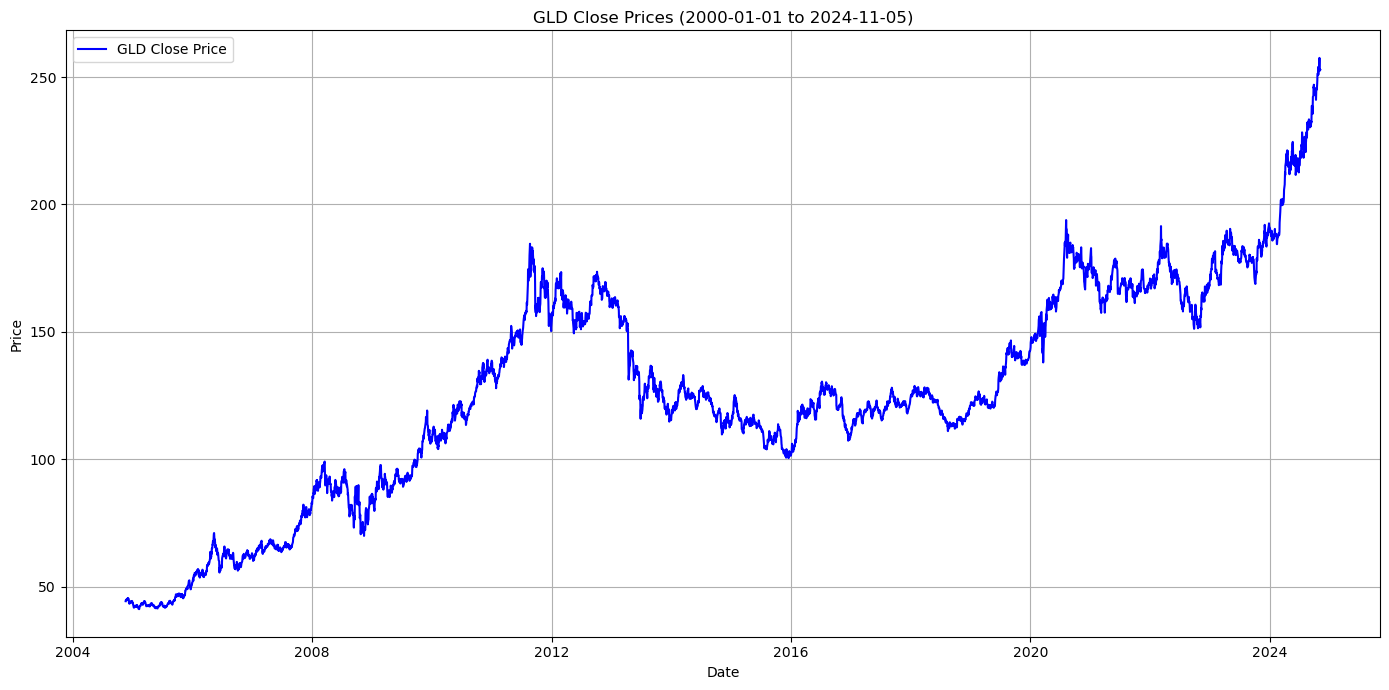

2024-11-05 17:23:51,309 - INFO - GLD prices saved to './data/GLD-Prices.csv'.
2024-11-05 17:23:51,319 - INFO - Initializing RESTClient for SLV...
2024-11-05 17:23:51,321 - INFO - Fetching aggregate bars data for 'SLV' from 2000-01-01 to 2024-11-05...



Fetching data for SLV...


2024-11-05 17:23:52,211 - INFO - Converting response to DataFrame for SLV...


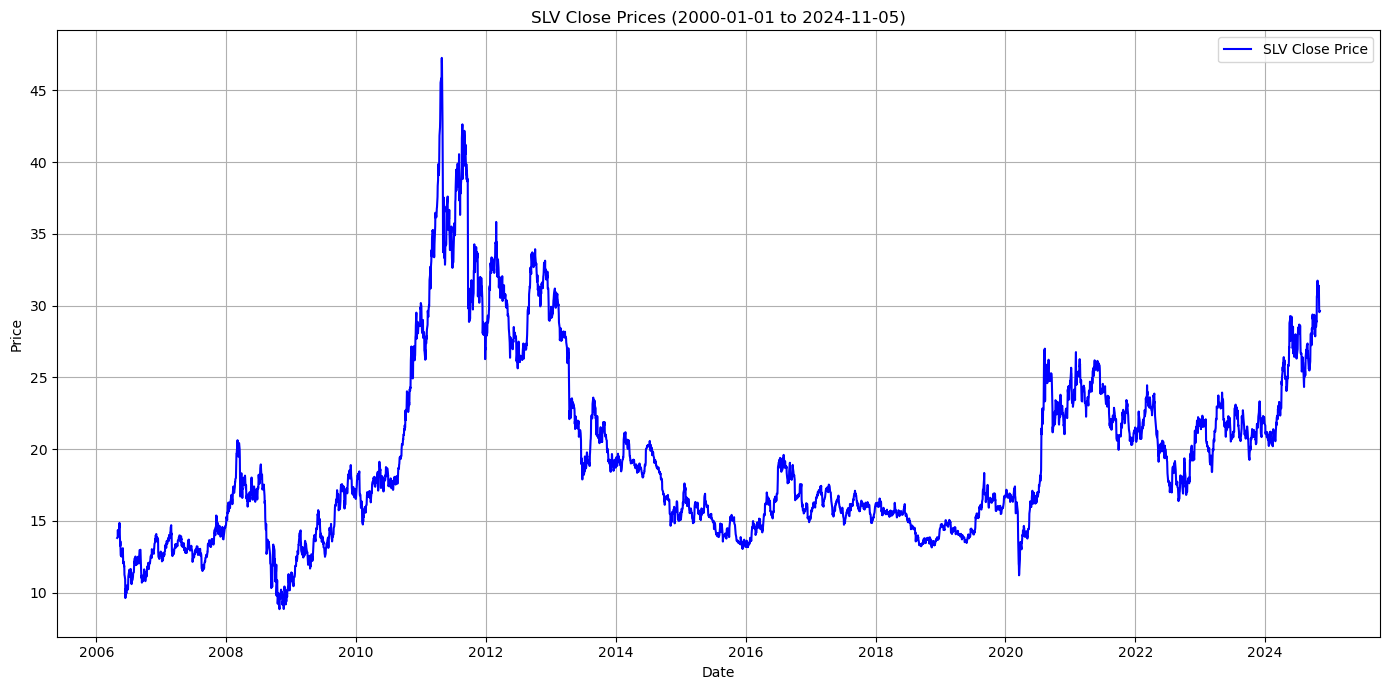

2024-11-05 17:23:52,369 - INFO - SLV prices saved to './data/SLV-Prices.csv'.
2024-11-05 17:23:52,372 - INFO - Initializing RESTClient for UNL...
2024-11-05 17:23:52,373 - INFO - Fetching aggregate bars data for 'UNL' from 2000-01-01 to 2024-11-05...



Fetching data for UNL...


2024-11-05 17:23:53,425 - INFO - Converting response to DataFrame for UNL...


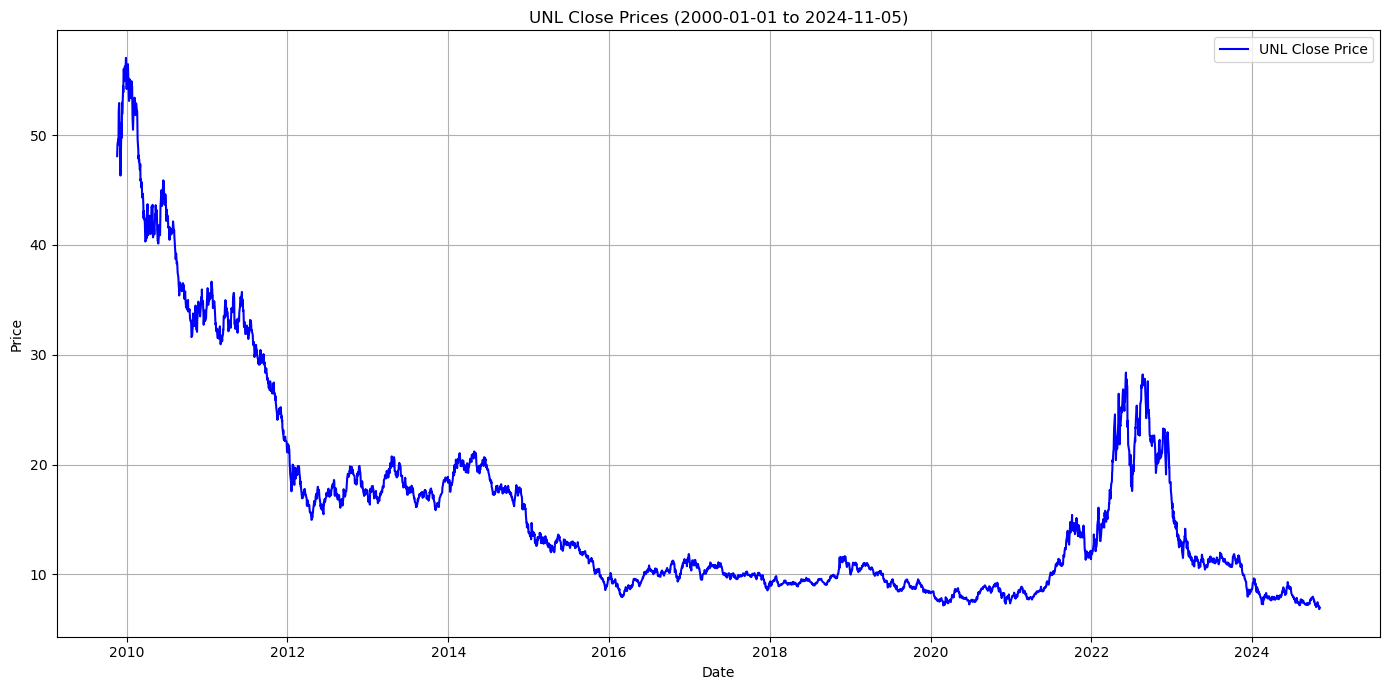

2024-11-05 17:23:53,573 - INFO - UNL prices saved to './data/UNL-Prices.csv'.
2024-11-05 17:23:53,575 - INFO - Initializing RESTClient for DBA...
2024-11-05 17:23:53,576 - INFO - Fetching aggregate bars data for 'DBA' from 2000-01-01 to 2024-11-05...



Fetching data for DBA...


2024-11-05 17:23:55,864 - INFO - Converting response to DataFrame for DBA...


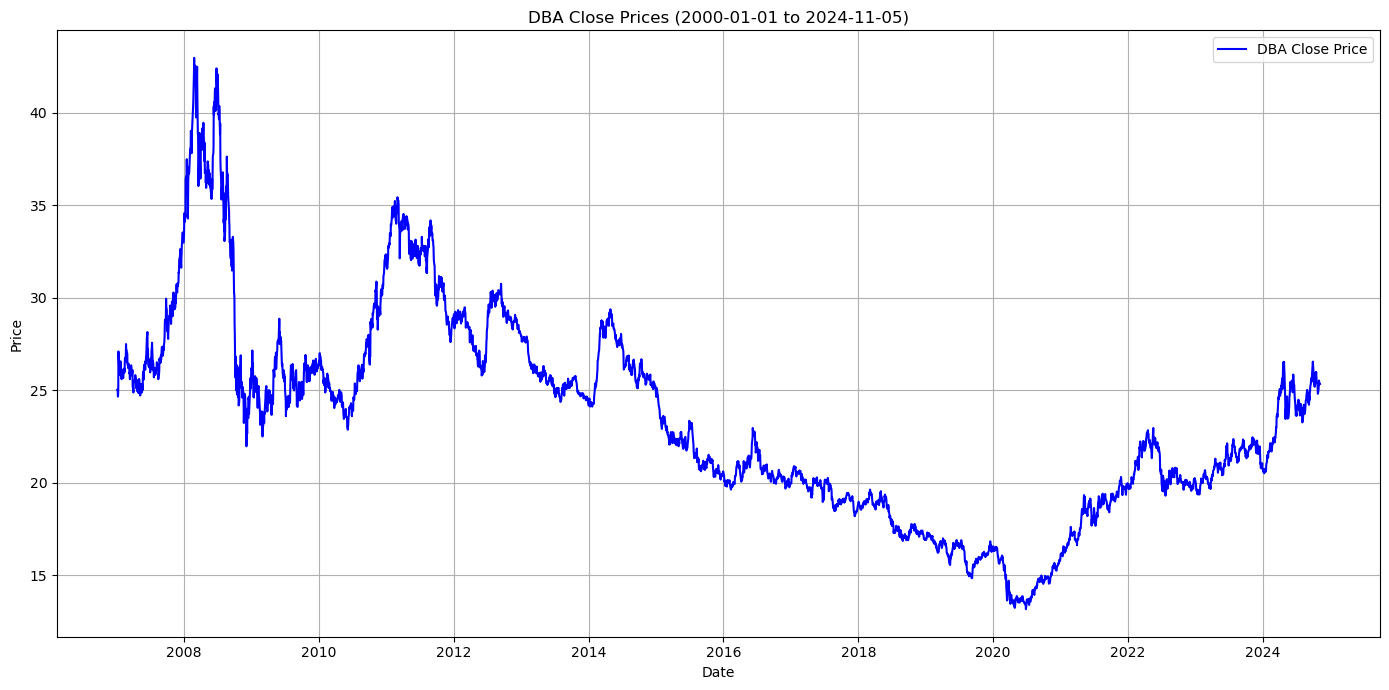

2024-11-05 17:23:56,048 - INFO - DBA prices saved to './data/DBA-Prices.csv'.
2024-11-05 17:23:56,052 - INFO - Initializing RESTClient for BG...
2024-11-05 17:23:56,053 - INFO - Fetching aggregate bars data for 'BG' from 2000-01-01 to 2024-11-05...



Fetching data for BG...


2024-11-05 17:23:58,280 - INFO - Converting response to DataFrame for BG...


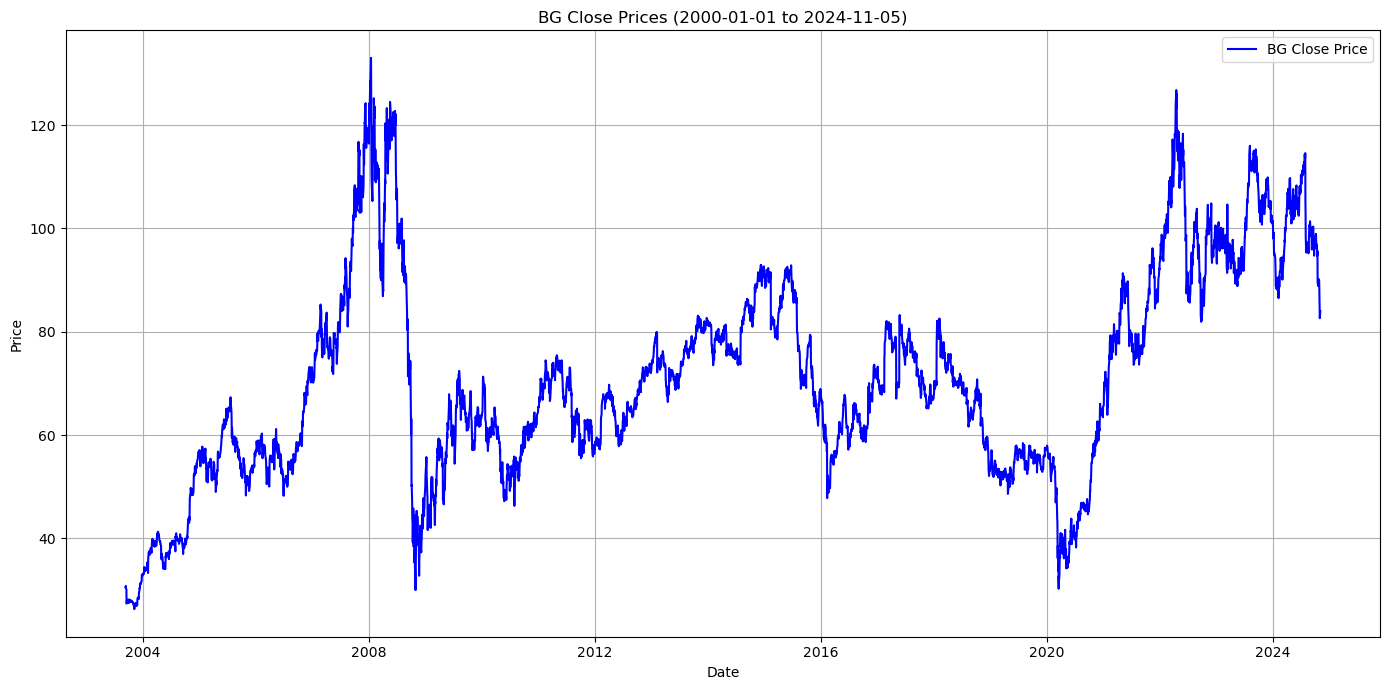

2024-11-05 17:23:58,442 - INFO - BG prices saved to './data/BG-Prices.csv'.
2024-11-05 17:23:58,446 - INFO - Initializing RESTClient for CORN...
2024-11-05 17:23:58,447 - INFO - Fetching aggregate bars data for 'CORN' from 2000-01-01 to 2024-11-05...



Fetching data for CORN...


2024-11-05 17:23:59,357 - INFO - Converting response to DataFrame for CORN...


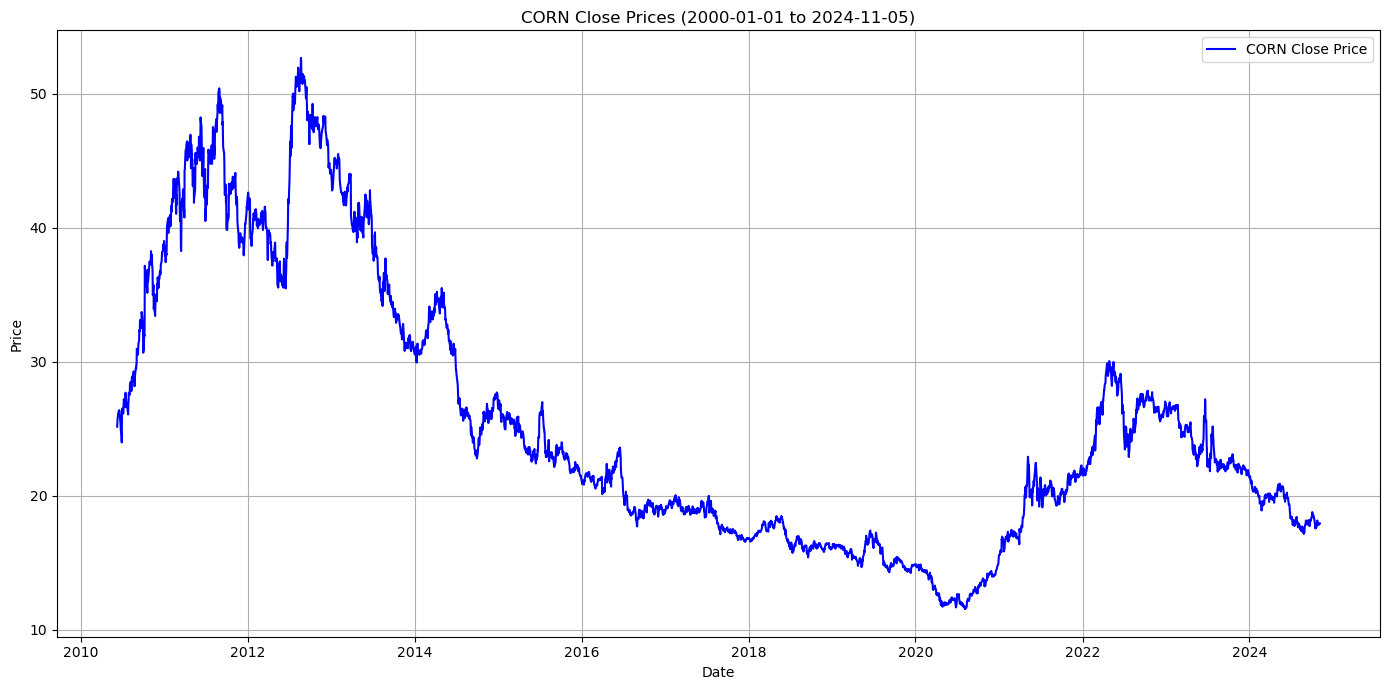

2024-11-05 17:23:59,607 - INFO - CORN prices saved to './data/CORN-Prices.csv'.
2024-11-05 17:23:59,621 - INFO - Initializing RESTClient for WEAT...
2024-11-05 17:23:59,623 - INFO - Fetching aggregate bars data for 'WEAT' from 2000-01-01 to 2024-11-05...



Fetching data for WEAT...


2024-11-05 17:24:28,164 - WARNING - Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'RemoteDisconnected('Remote end closed connection without response')': /v2/aggs/ticker/WEAT/range/1/day/2000-01-01/2024-11-05?limit=50000
2024-11-05 17:24:29,382 - INFO - Converting response to DataFrame for WEAT...


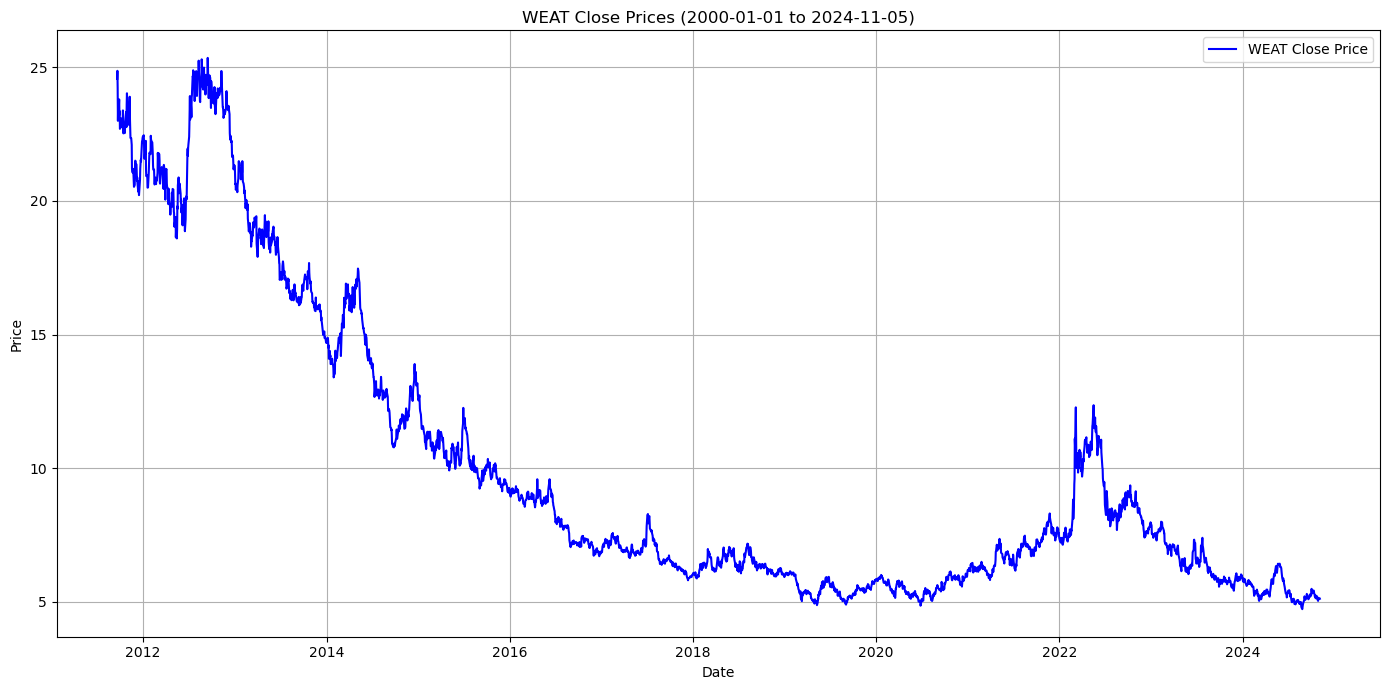

2024-11-05 17:24:30,351 - INFO - WEAT prices saved to './data/WEAT-Prices.csv'.


In [31]:
# Replace 'YOUR_POLYGON_API_KEY' with your actual Polygon.io API key
API_KEY = 'uwQtl3txGt5BLbecq7ZbIu0ZbuitCGjc'

# Define the date range
start_date = '2000-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# List of tickers
tickers = ['GLD', 'SLV', 'UNL', 'DBA', 'BG', 'CORN', 'WEAT']

# Dictionary to hold data for each ticker
asset_data = {}

# Fetch and plot data for each ticker
for ticker in tickers:
    print(f"\nFetching data for {ticker}...")
    data = get_asset_data(ticker, start_date, end_date, API_KEY, plot=True)
    if data is not None:
        asset_data[ticker] = data
    else:
        logging.error(f"Data retrieval failed for {ticker}.")

In [32]:
def perform_stationarity_tests(series, signif=0.05, verbose=False):
    """
    Performs both ADF and KPSS tests on the given series.
    """
    results = {}

    # Augmented Dickey-Fuller Test
    try:
        adf_test = adfuller(series, autolag='AIC')
        adf_stat = adf_test[0]
        adf_pvalue = adf_test[1]
        results['ADF'] = {'Test Statistic': adf_stat, 'p-value': adf_pvalue}
        if verbose:
            print('ADF Test:')
            print(f"Test Statistic: {adf_stat}, p-value: {adf_pvalue}")
    except Exception as e:
        logging.error(f"ADF test failed: {e}")
        results['ADF'] = None

    # KPSS Test
    try:
        kpss_test = kpss(series, regression='c', nlags='auto')
        kpss_stat = kpss_test[0]
        kpss_pvalue = kpss_test[1]
        results['KPSS'] = {'Test Statistic': kpss_stat, 'p-value': kpss_pvalue}
        if verbose:
            print('KPSS Test:')
            print(f"Test Statistic: {kpss_stat}, p-value: {kpss_pvalue}")
    except Exception as e:
        logging.error(f"KPSS test failed: {e}")
        results['KPSS'] = None

    return results


def determine_optimal_differencing(series, max_d=2, signif=0.05, verbose=False):
    """
    Determines the optimal differencing order 'd' for the series.
    """
    for d in range(max_d + 1):
        if d == 0:
            differenced_series = series.copy()
        else:
            differenced_series = series.diff(d).dropna()
        test_results = perform_stationarity_tests(
            differenced_series, signif=signif, verbose=verbose)
        adf_pvalue = test_results['ADF']['p-value'] if test_results['ADF'] else None
        kpss_pvalue = test_results['KPSS']['p-value'] if test_results['KPSS'] else None

        adf_stationary = adf_pvalue is not None and adf_pvalue < signif
        kpss_stationary = kpss_pvalue is not None and kpss_pvalue >= signif

        if verbose:
            print(
                f"Differencing order d={d}: ADF stationary={adf_stationary}, KPSS stationary={kpss_stationary}")

        if adf_stationary and kpss_stationary:
            if verbose:
                print(f"Optimal differencing order determined: d={d}")
            return d

    if verbose:
        print(
            f"No optimal differencing order found up to d={max_d}. Using d={max_d}")
    return max_d

In [33]:
# Dictionary to hold differencing orders
d_values = {}

for ticker in tickers:
    print(f"\n{ticker} Stationarity Testing:")
    close_series = asset_data[ticker]['Close']
    d = determine_optimal_differencing(close_series, verbose=True)
    d_values[ticker] = d


GLD Stationarity Testing:
ADF Test:
Test Statistic: -0.037428903338151694, p-value: 0.955325098008242
KPSS Test:
Test Statistic: 7.732473205417877, p-value: 0.01
Differencing order d=0: ADF stationary=False, KPSS stationary=False
ADF Test:
Test Statistic: -71.14273896671072, p-value: 0.0
KPSS Test:
Test Statistic: 0.18387707365642775, p-value: 0.1
Differencing order d=1: ADF stationary=True, KPSS stationary=True
Optimal differencing order determined: d=1

SLV Stationarity Testing:
ADF Test:
Test Statistic: -2.0131859397588188, p-value: 0.2808216193640495
KPSS Test:
Test Statistic: 0.8834639594074704, p-value: 0.01
Differencing order d=0: ADF stationary=False, KPSS stationary=False
ADF Test:
Test Statistic: -13.584796534172769, p-value: 2.090436296028099e-25
KPSS Test:
Test Statistic: 0.06355056403154899, p-value: 0.1
Differencing order d=1: ADF stationary=True, KPSS stationary=True
Optimal differencing order determined: d=1

UNL Stationarity Testing:
ADF Test:
Test Statistic: -4.27177

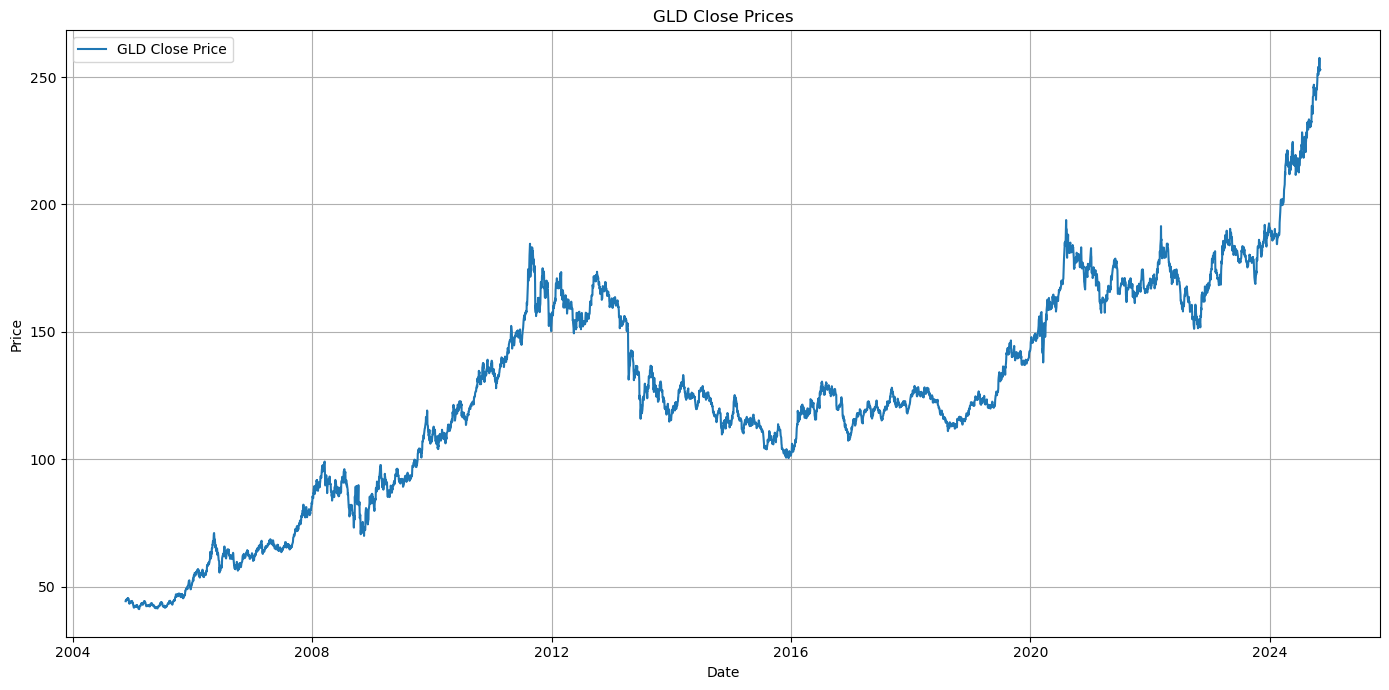

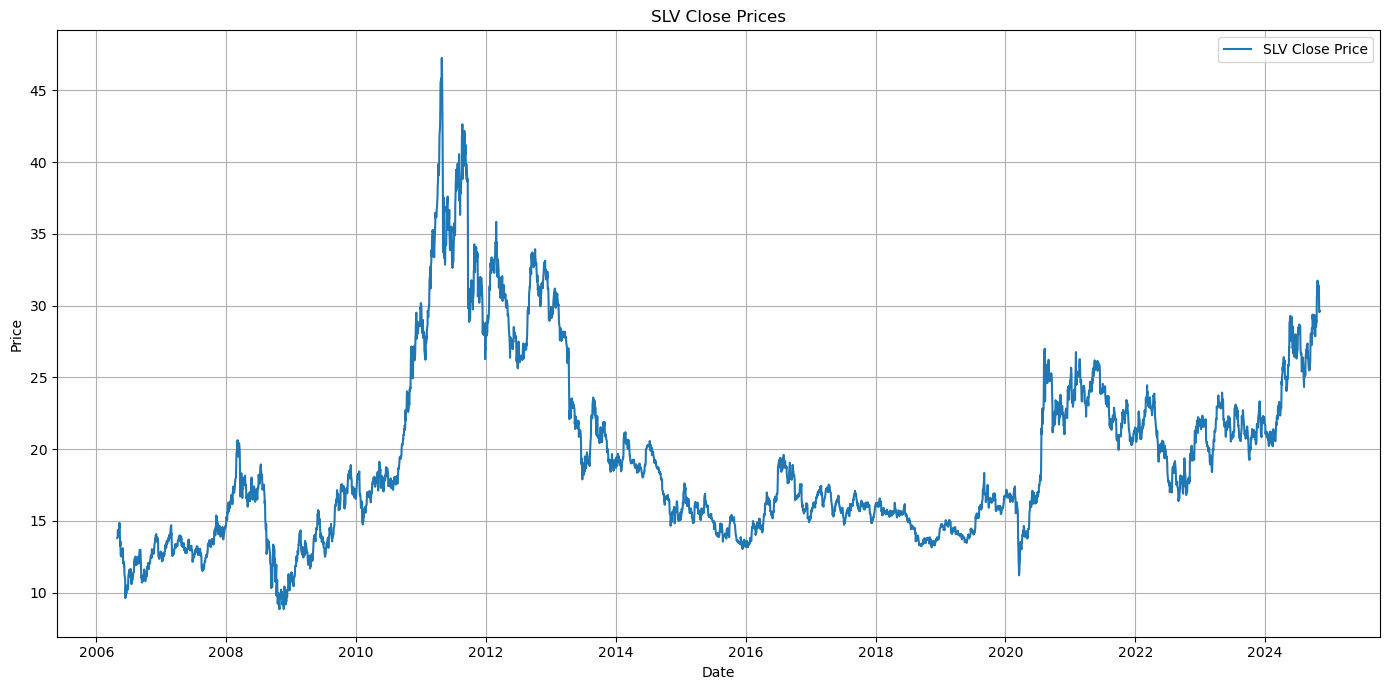

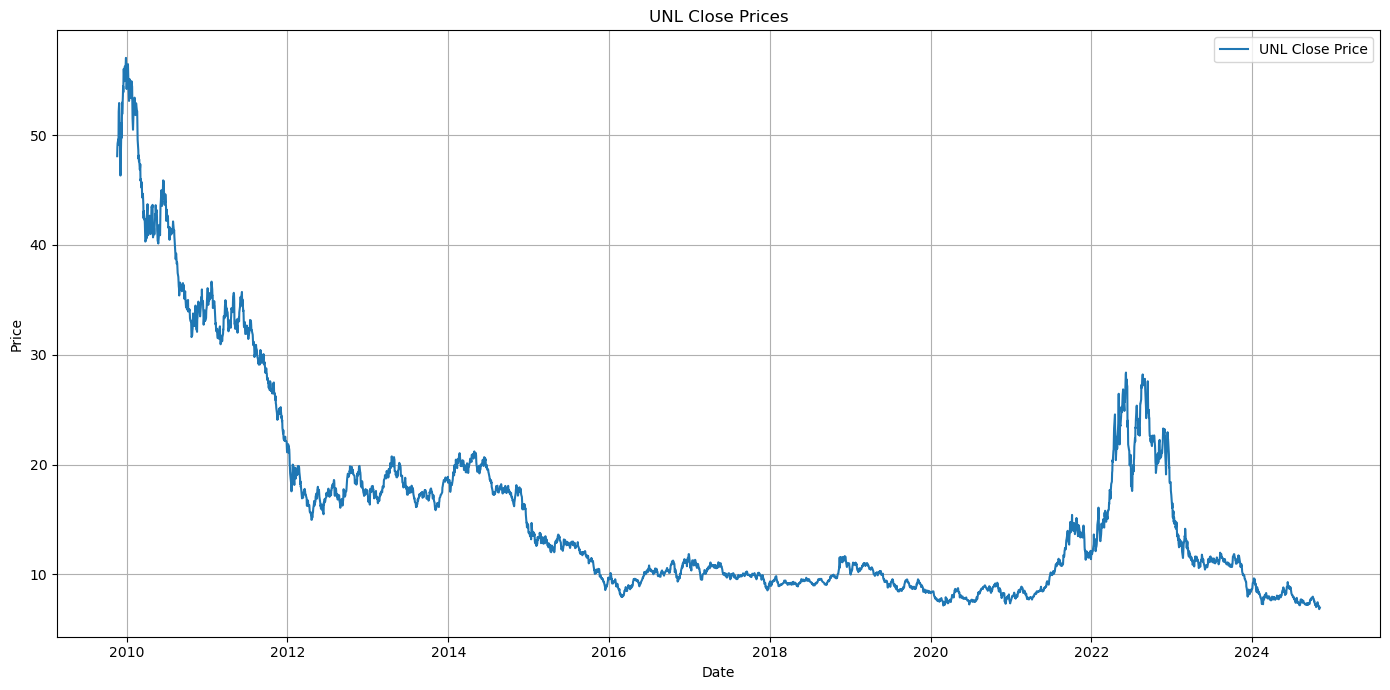

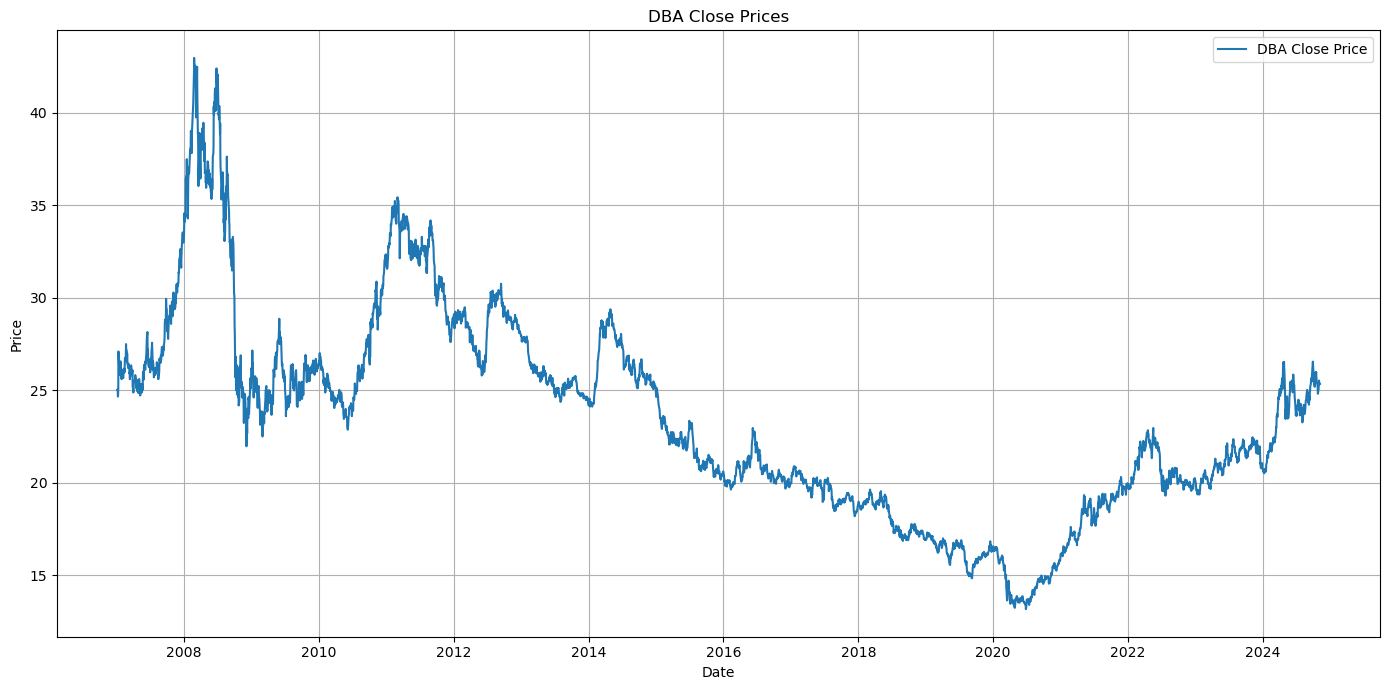

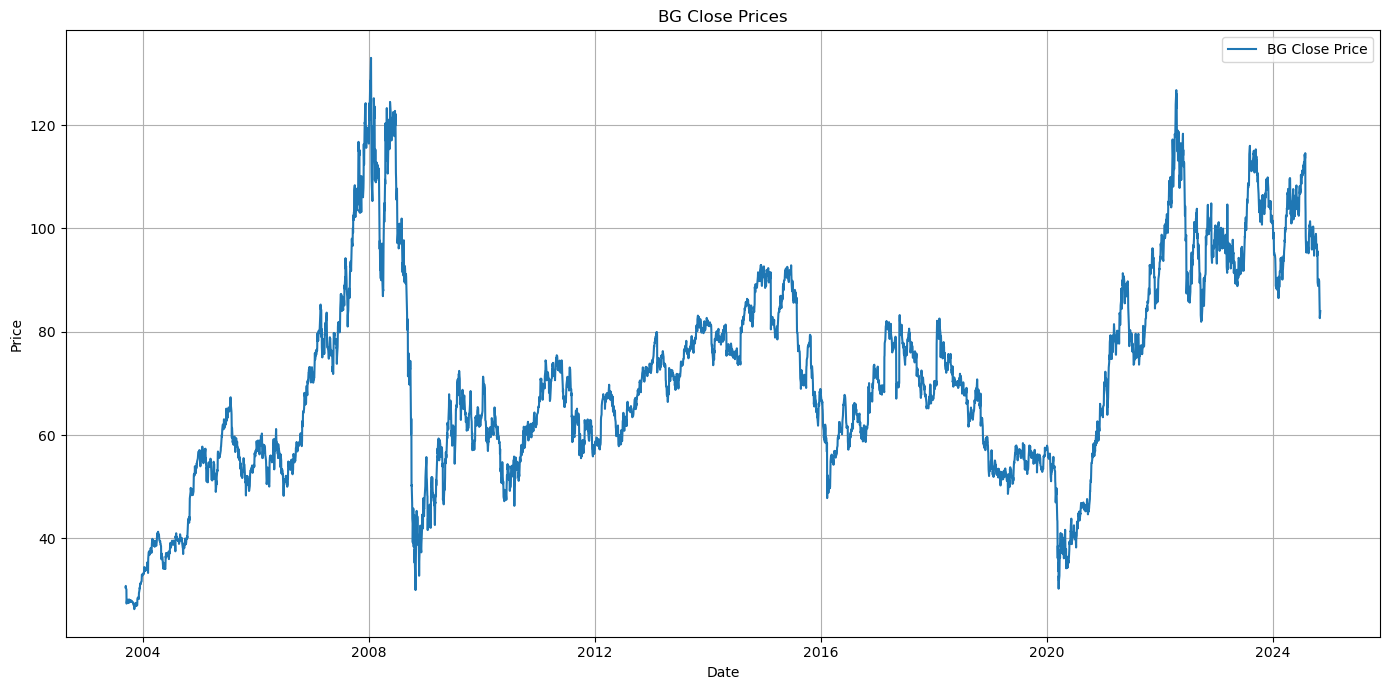

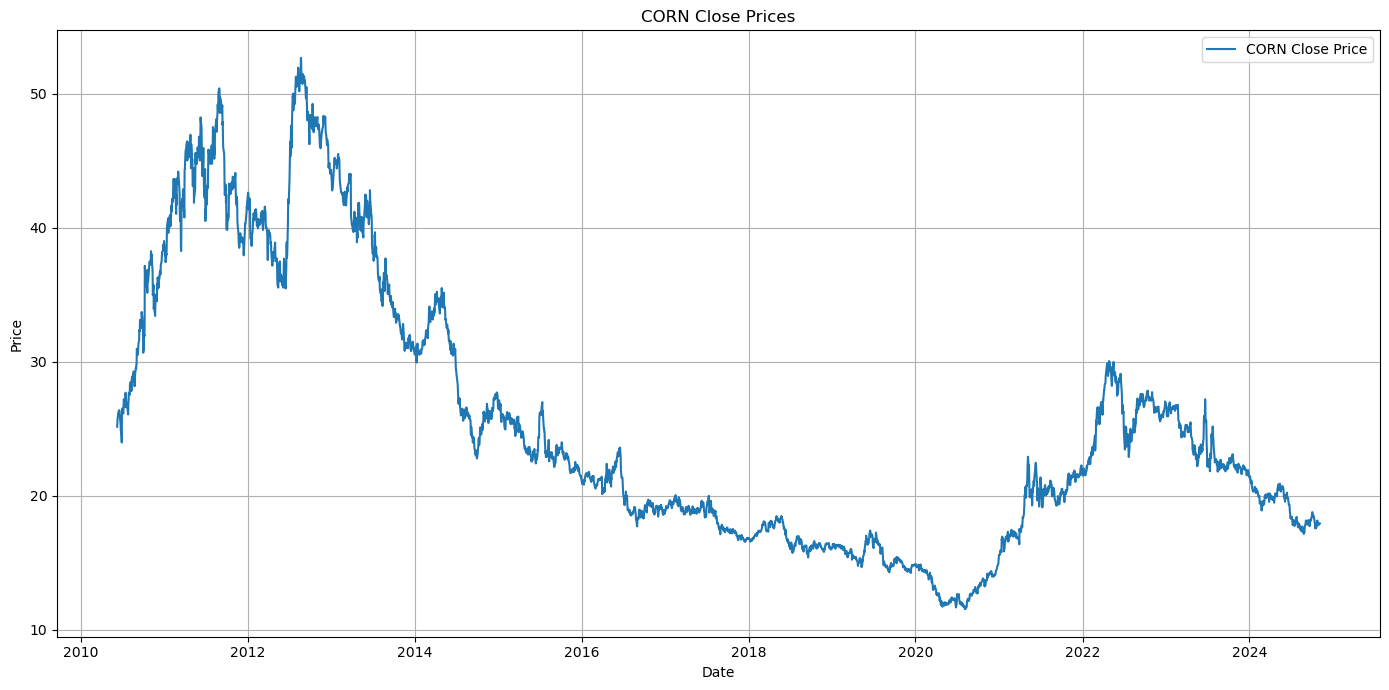

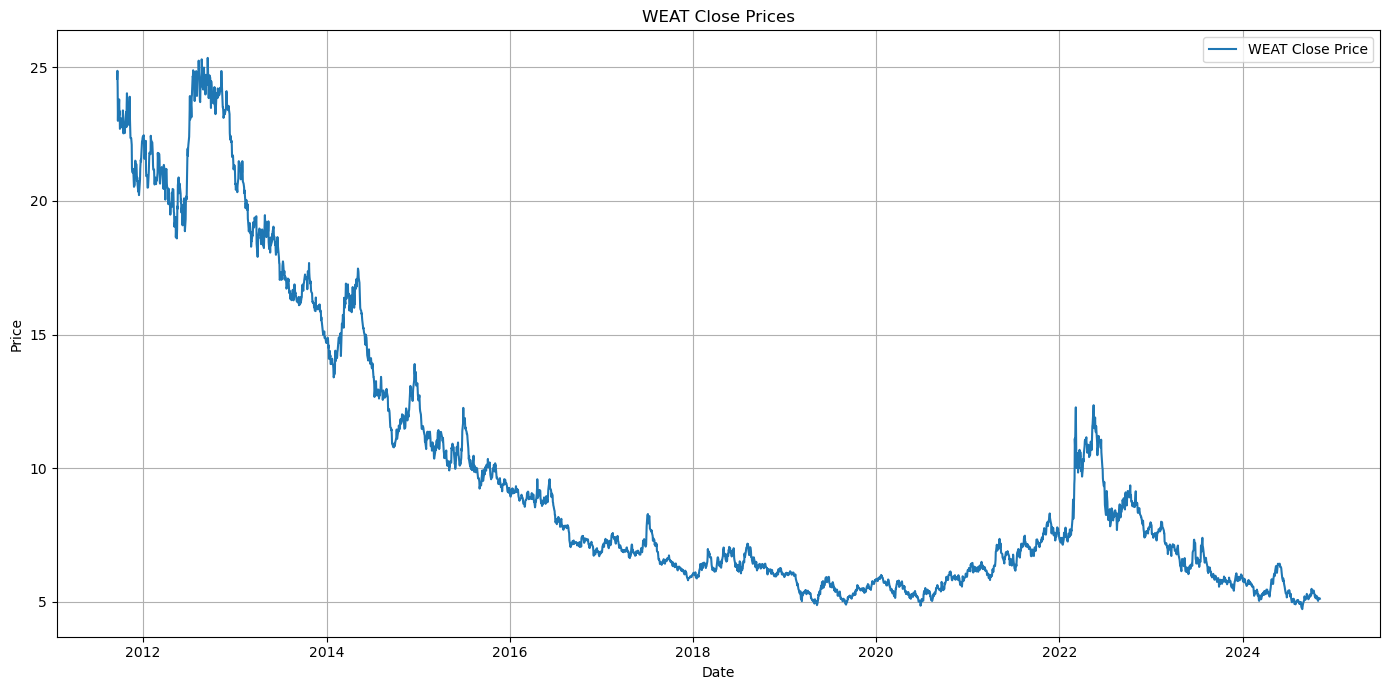

In [34]:
for ticker in tickers:
    plt.figure(figsize=(14, 7))
    plt.plot(asset_data[ticker]['Close'], label=f'{ticker} Close Price')
    plt.title(f'{ticker} Close Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [35]:
def seasonal_decomposition_analysis(series, seasonal_period, model='additive'):
    """
    Performs seasonal decomposition on a time series.
    """
    try:
        logging.info(
            f"Performing seasonal decomposition with period={seasonal_period} and model='{model}'...")
        decomposition = seasonal_decompose(
            series, model=model, period=seasonal_period)
        logging.info("Seasonal decomposition completed.")
        return decomposition
    except Exception as e:
        logging.error(f"An error occurred during seasonal decomposition: {e}")
        return None

2024-11-05 17:25:03,028 - INFO - Performing seasonal decomposition with period=365 and model='additive'...
2024-11-05 17:25:03,075 - INFO - Seasonal decomposition completed.



GLD Seasonal Decomposition:


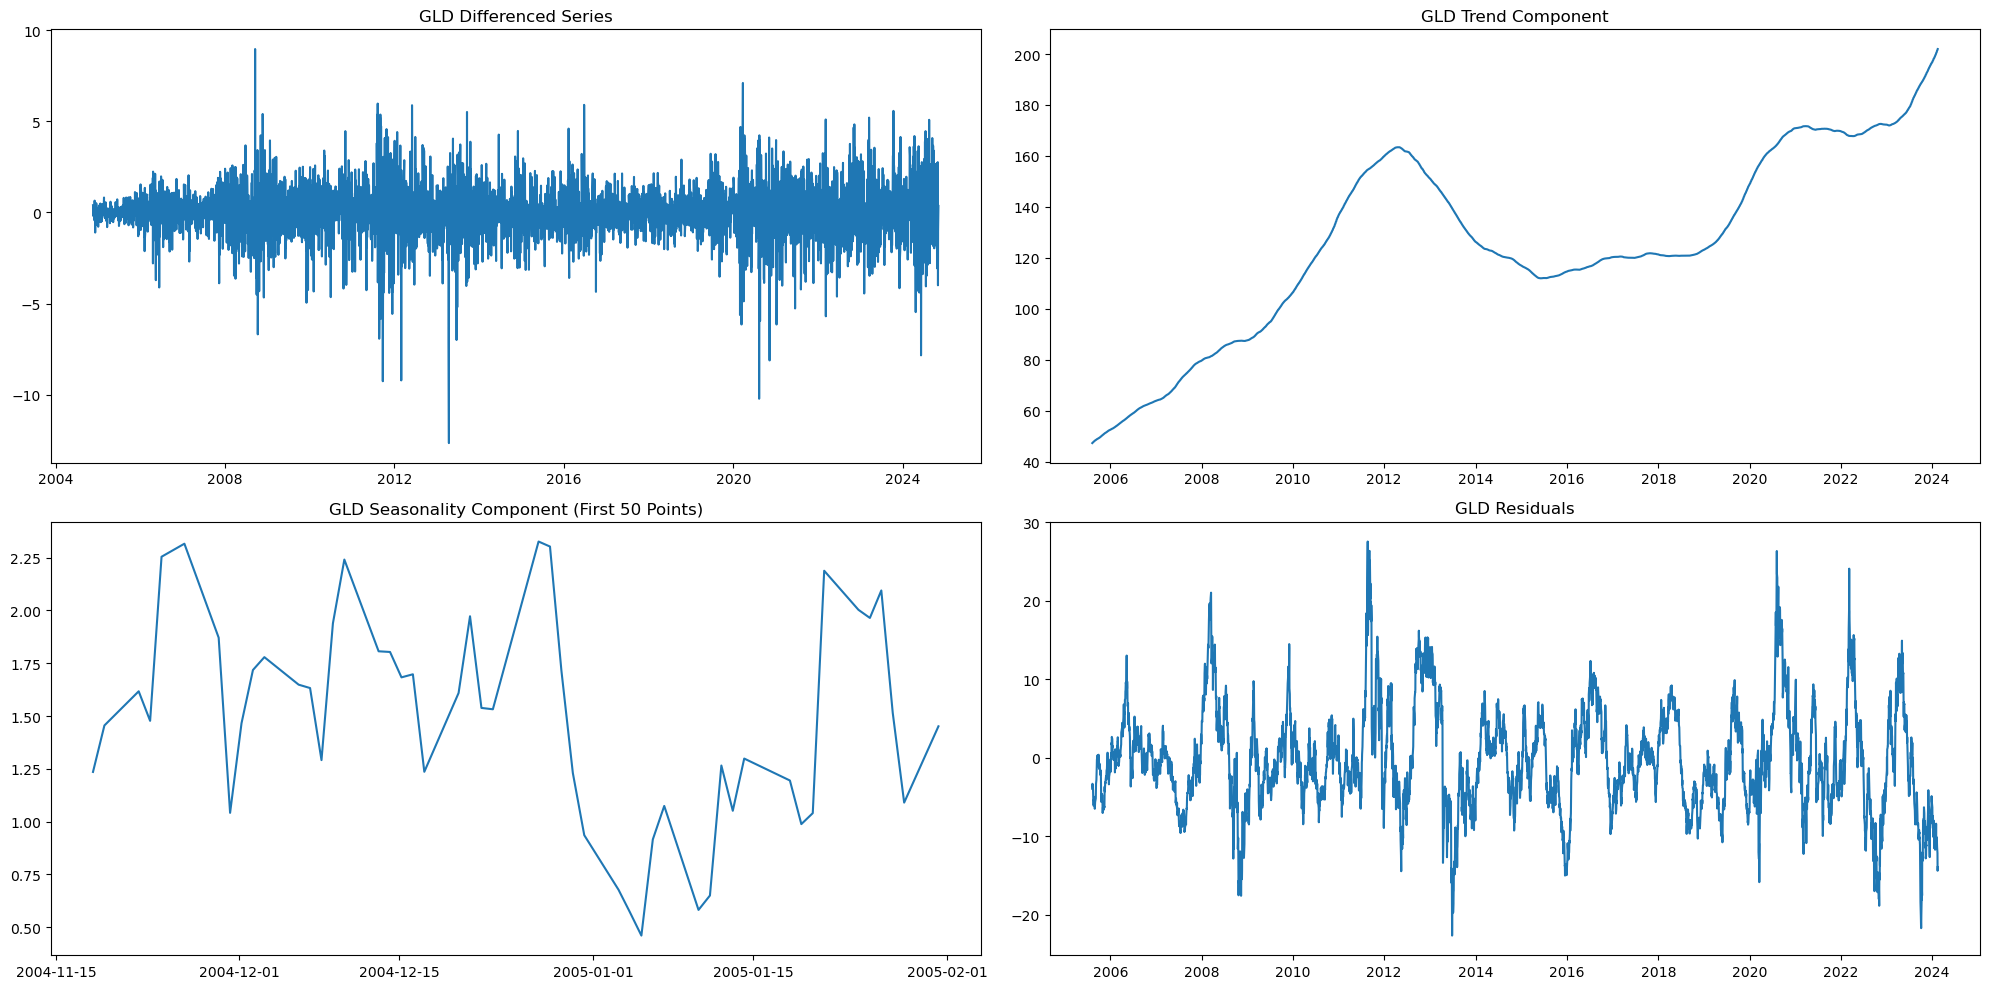

2024-11-05 17:25:03,711 - INFO - Performing seasonal decomposition with period=730 and model='additive'...
2024-11-05 17:25:03,728 - INFO - Seasonal decomposition completed.



GLD Seasonal Decomposition:


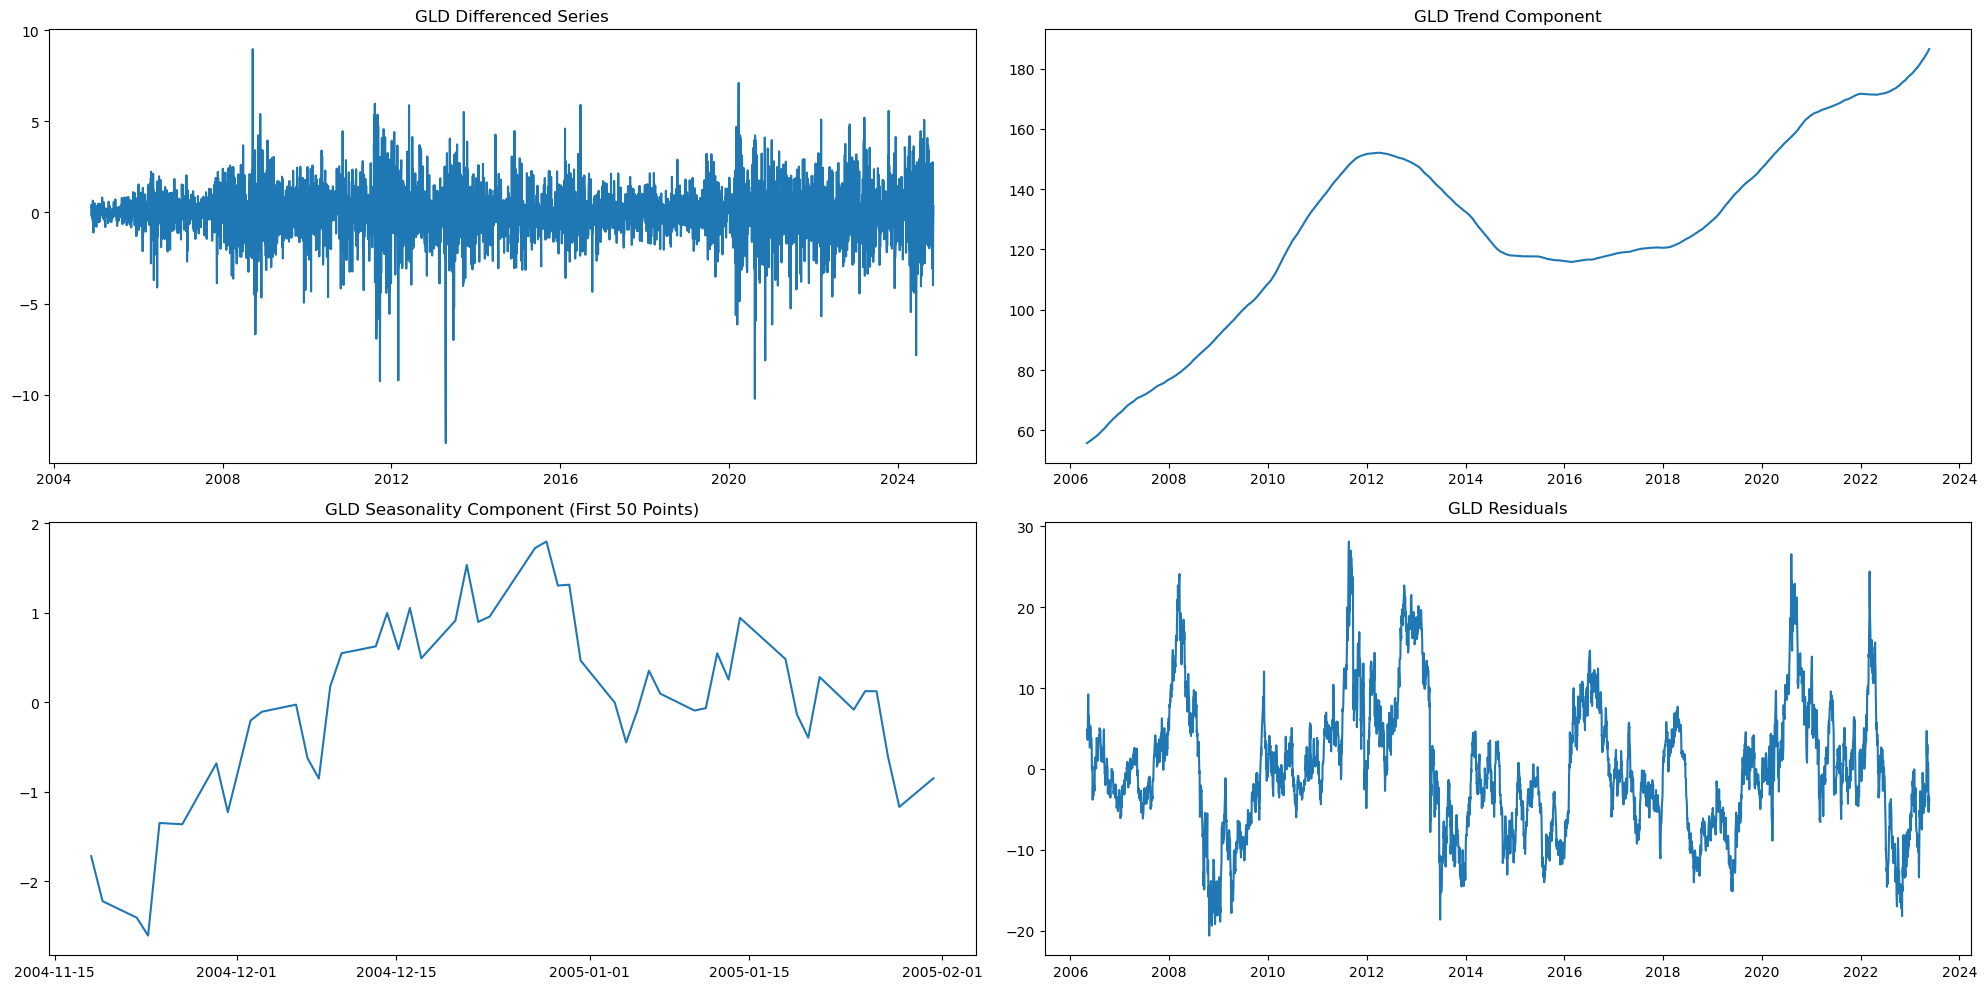

2024-11-05 17:25:04,342 - INFO - Performing seasonal decomposition with period=1825 and model='additive'...
2024-11-05 17:25:04,399 - INFO - Seasonal decomposition completed.



GLD Seasonal Decomposition:


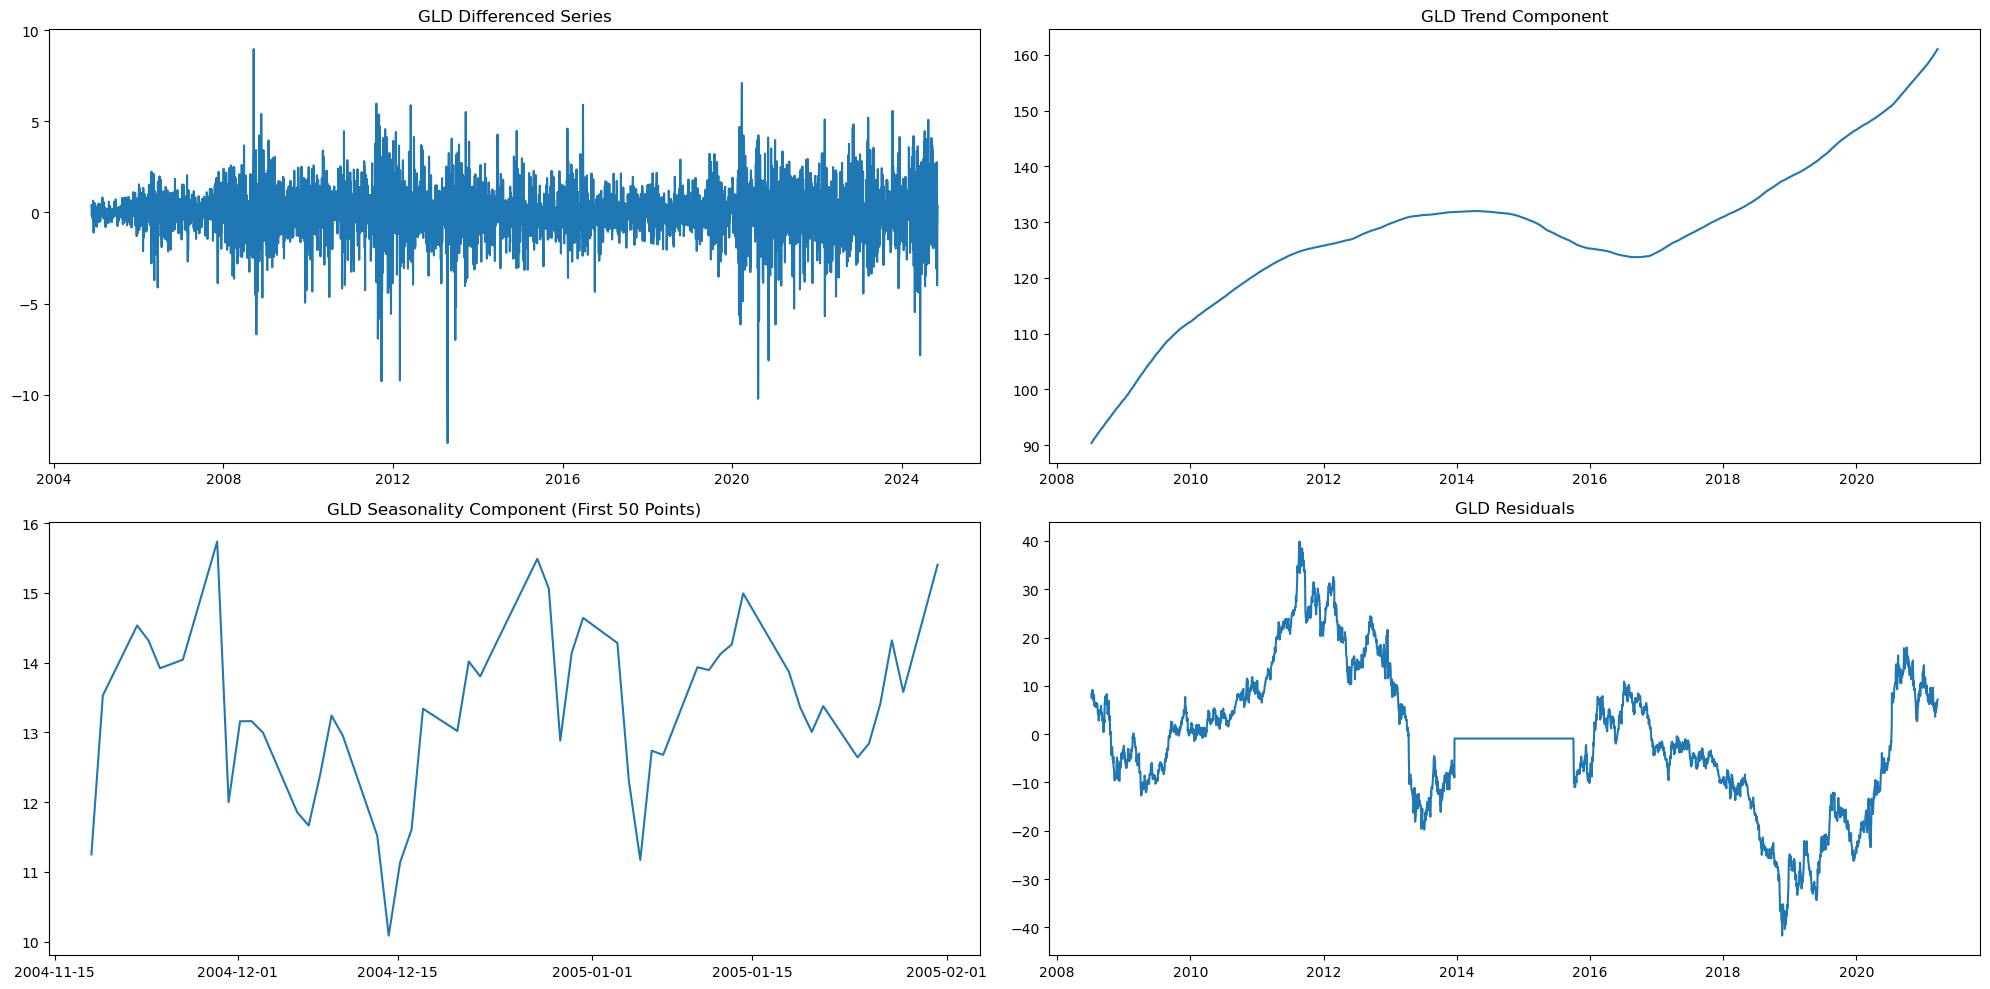

2024-11-05 17:25:04,839 - INFO - Performing seasonal decomposition with period=365 and model='additive'...
2024-11-05 17:25:04,843 - INFO - Seasonal decomposition completed.



SLV Seasonal Decomposition:


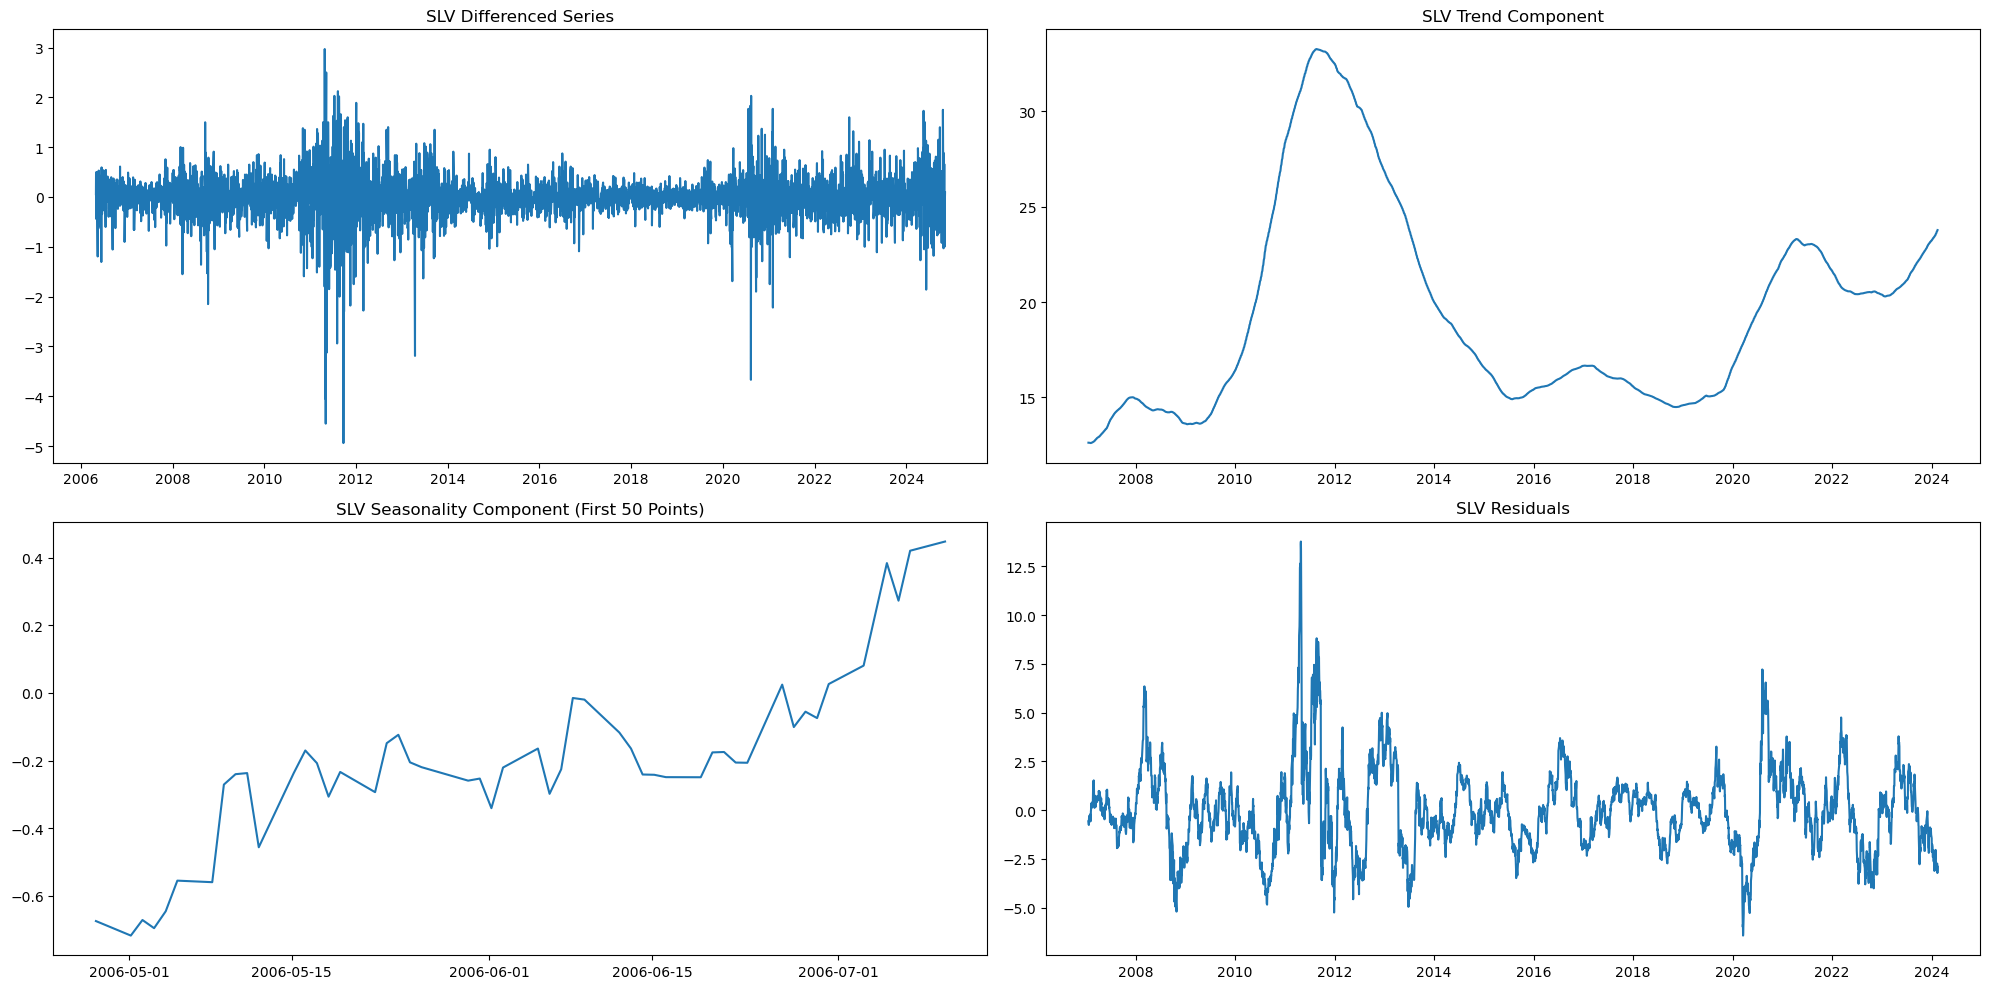

2024-11-05 17:25:05,783 - INFO - Performing seasonal decomposition with period=730 and model='additive'...
2024-11-05 17:25:05,791 - INFO - Seasonal decomposition completed.



SLV Seasonal Decomposition:


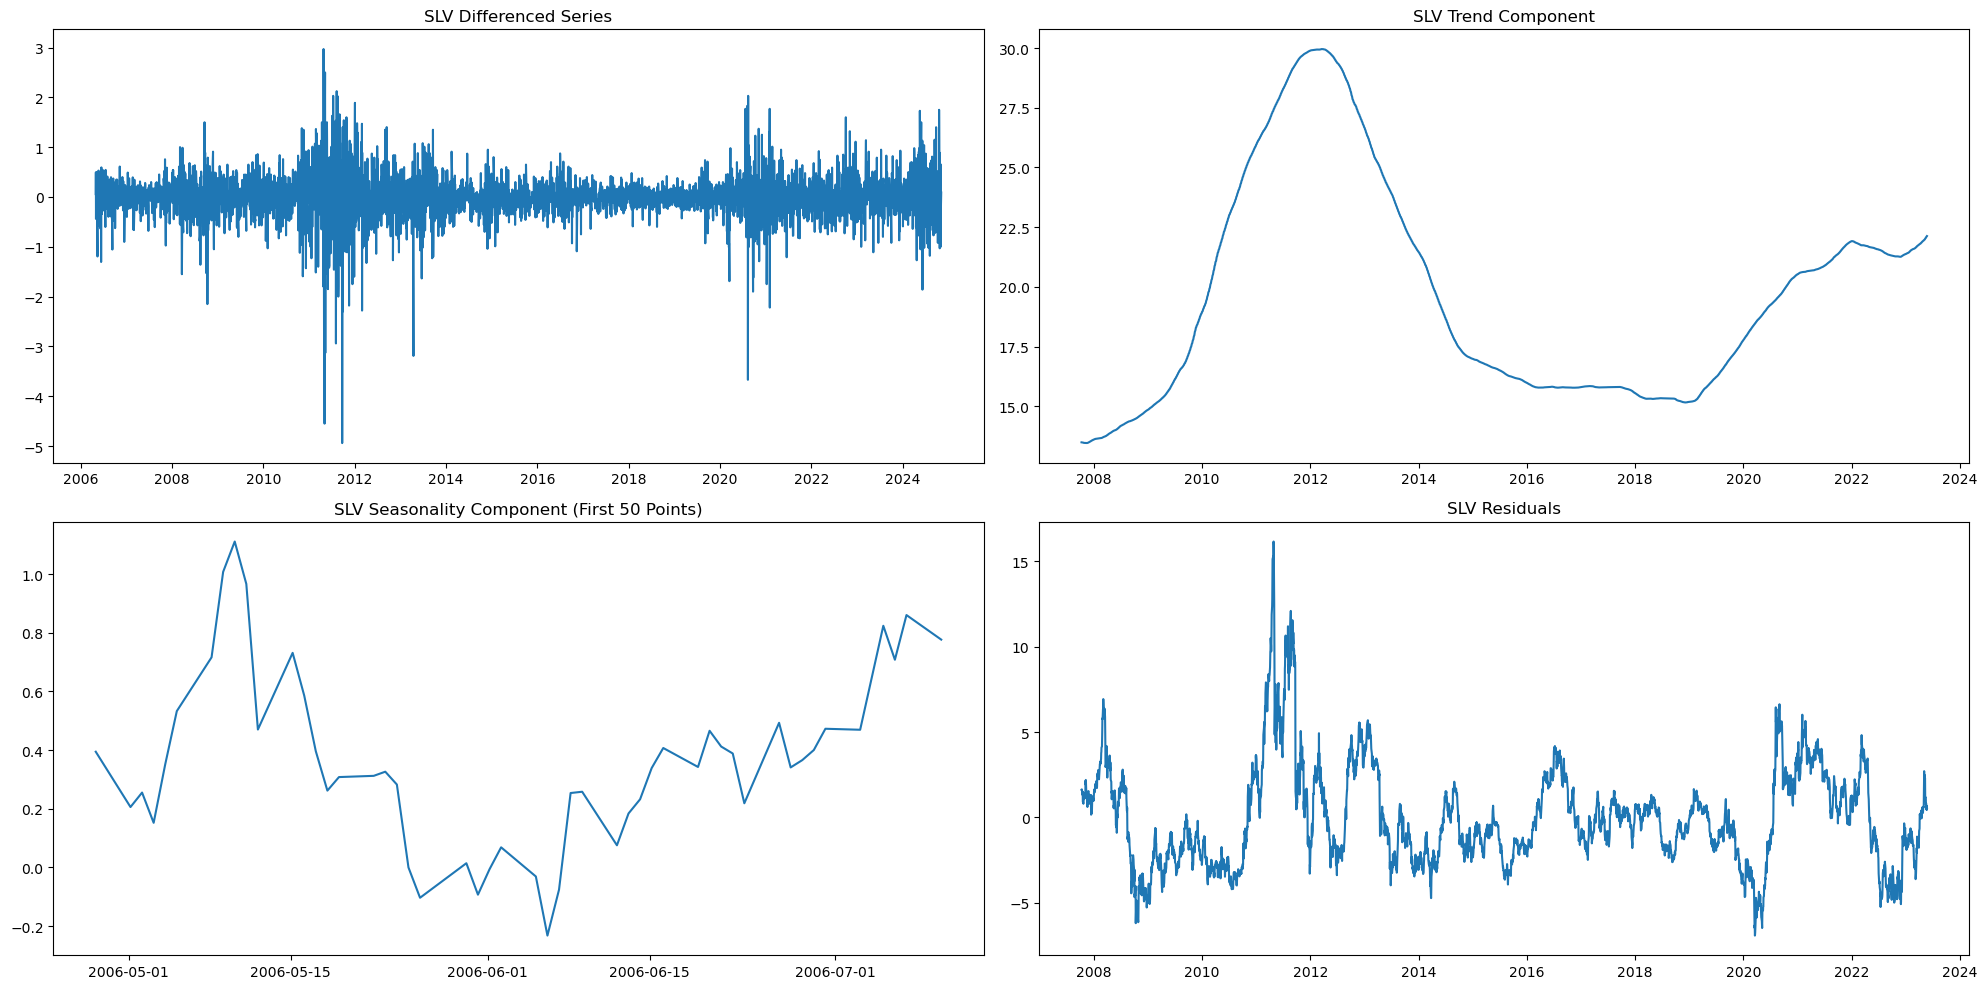

2024-11-05 17:25:06,297 - INFO - Performing seasonal decomposition with period=1825 and model='additive'...
2024-11-05 17:25:06,316 - INFO - Seasonal decomposition completed.



SLV Seasonal Decomposition:


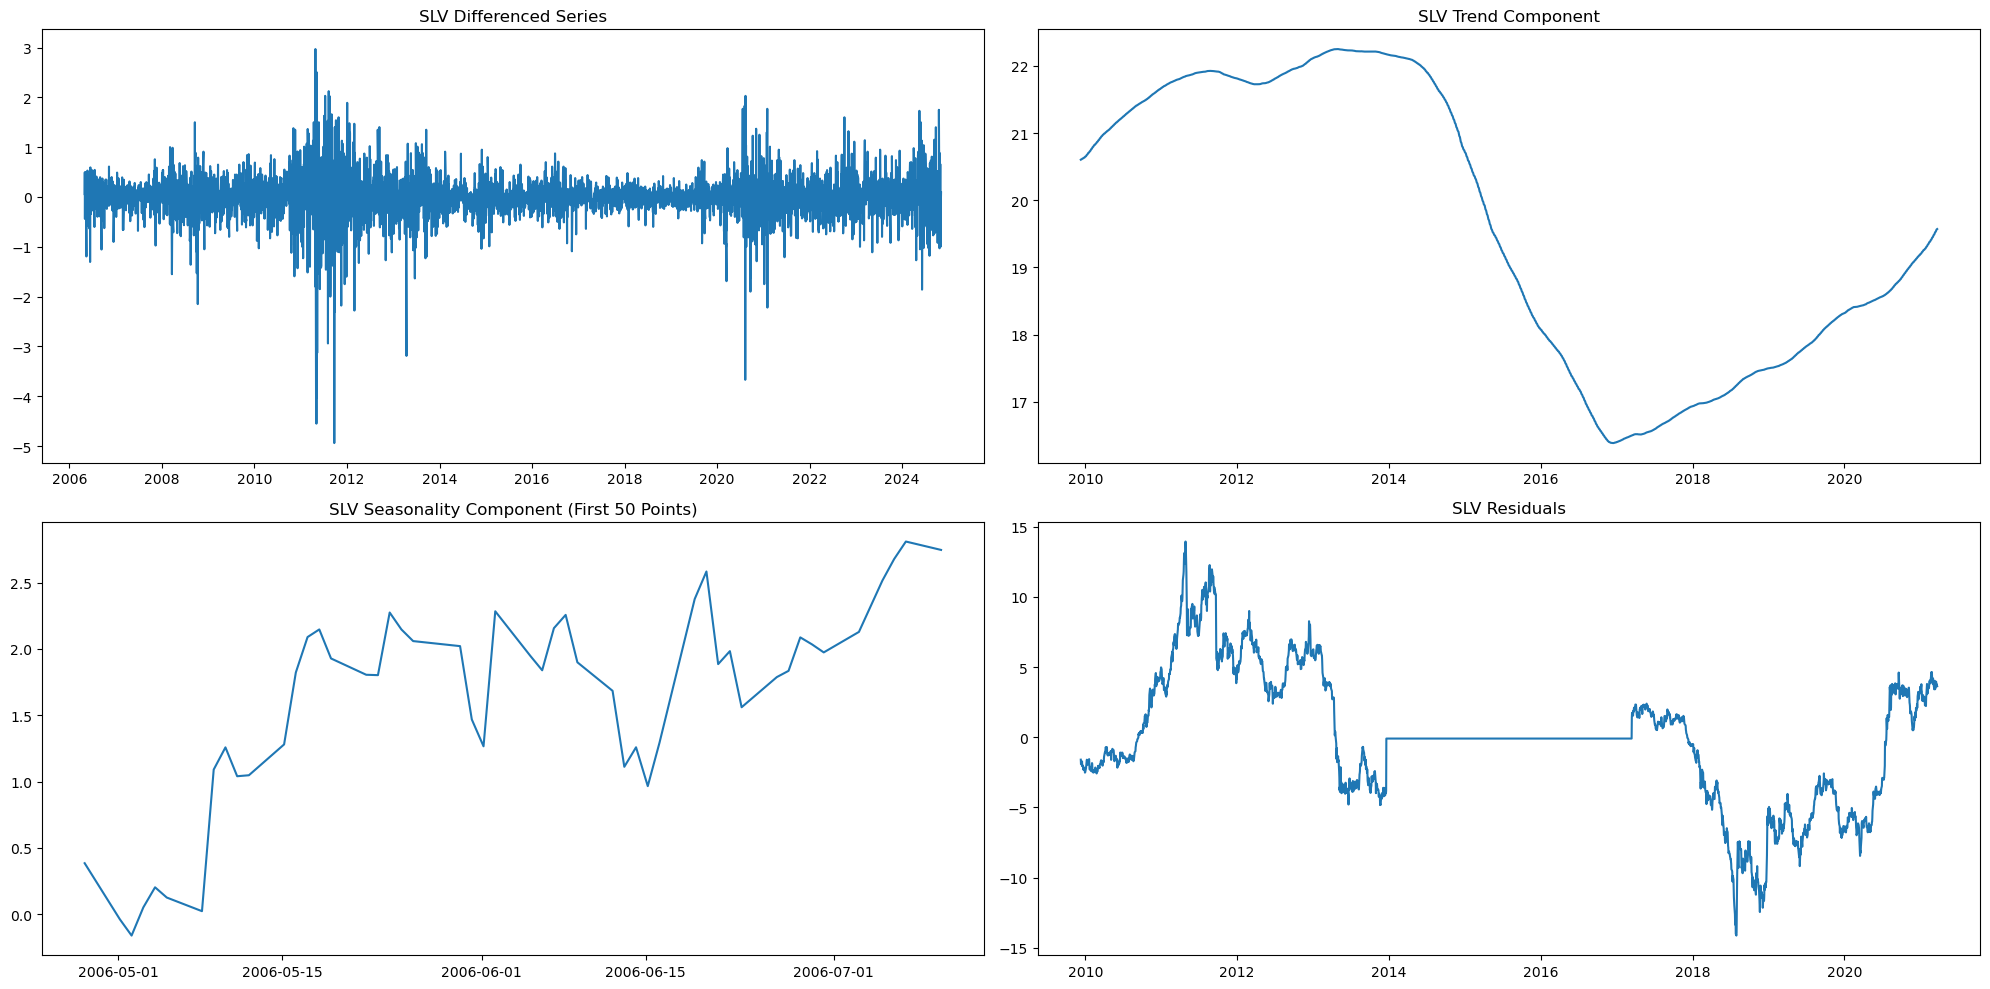

2024-11-05 17:25:06,858 - INFO - Performing seasonal decomposition with period=365 and model='additive'...
2024-11-05 17:25:06,863 - INFO - Seasonal decomposition completed.



UNL Seasonal Decomposition:


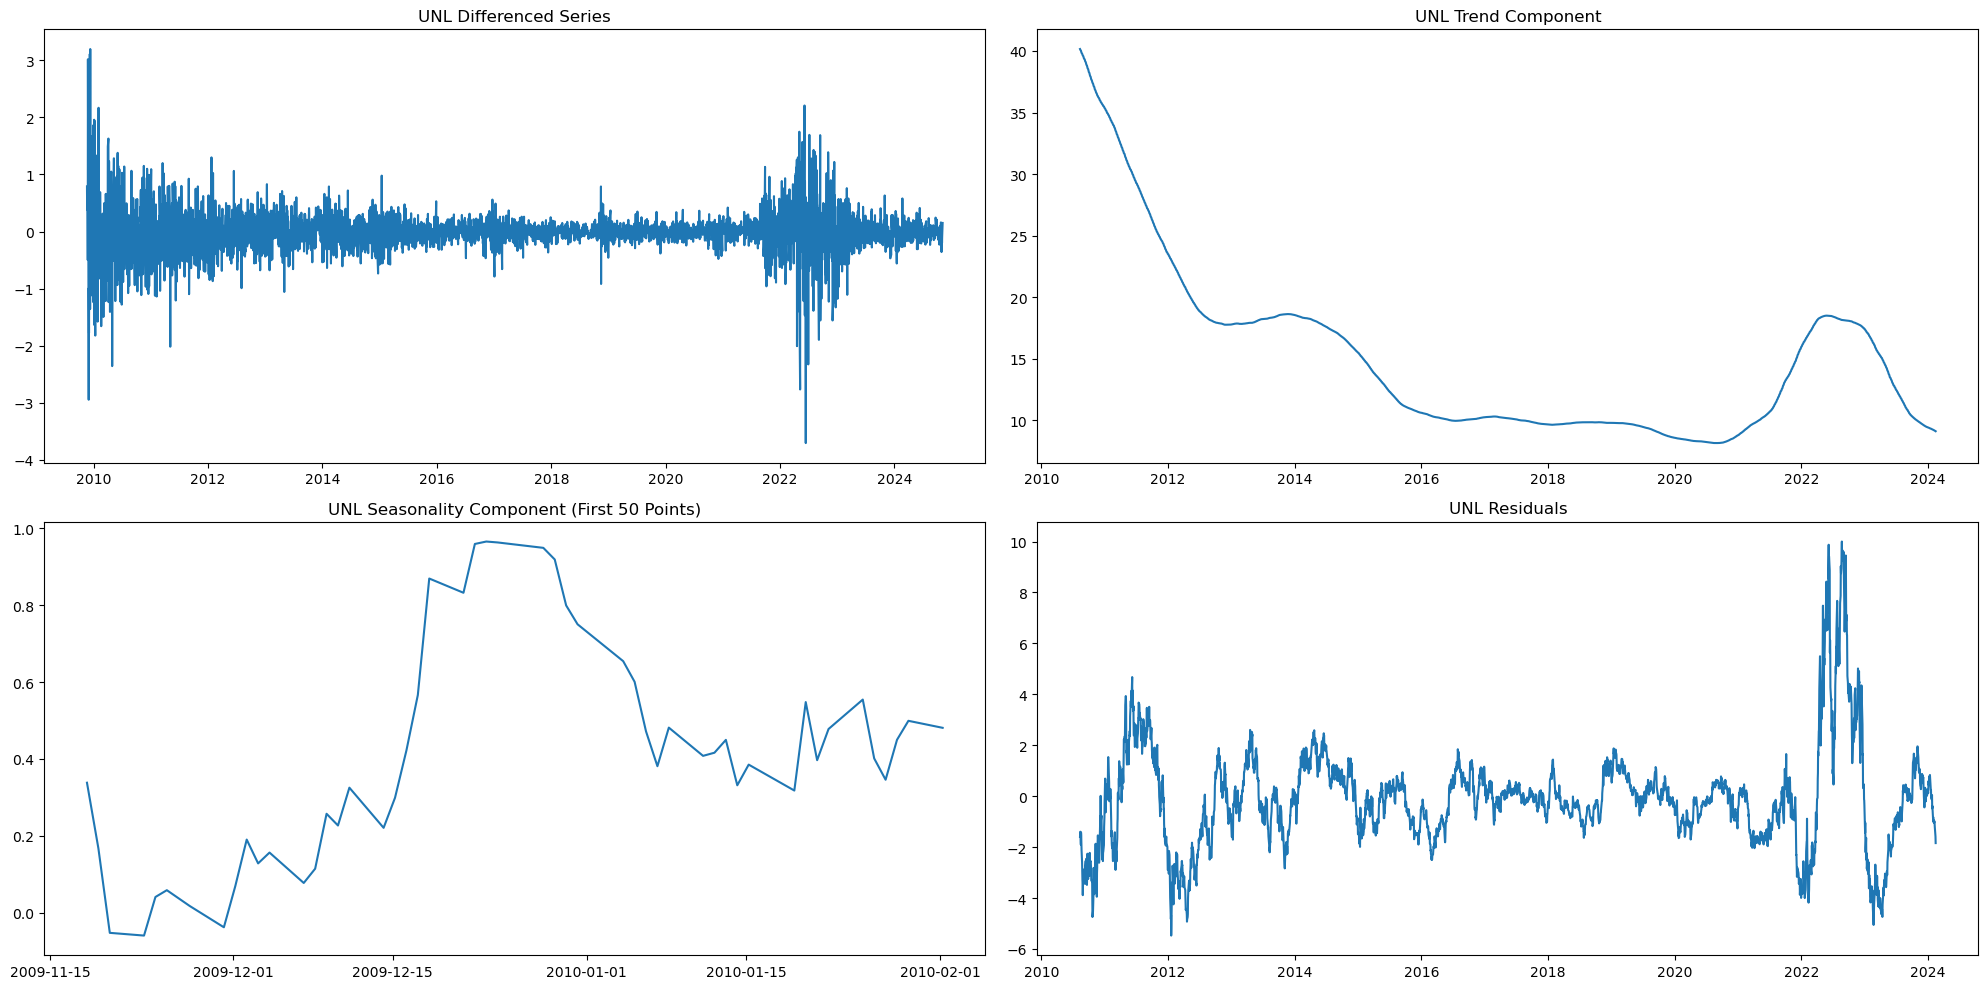

2024-11-05 17:25:07,332 - INFO - Performing seasonal decomposition with period=730 and model='additive'...
2024-11-05 17:25:07,341 - INFO - Seasonal decomposition completed.



UNL Seasonal Decomposition:


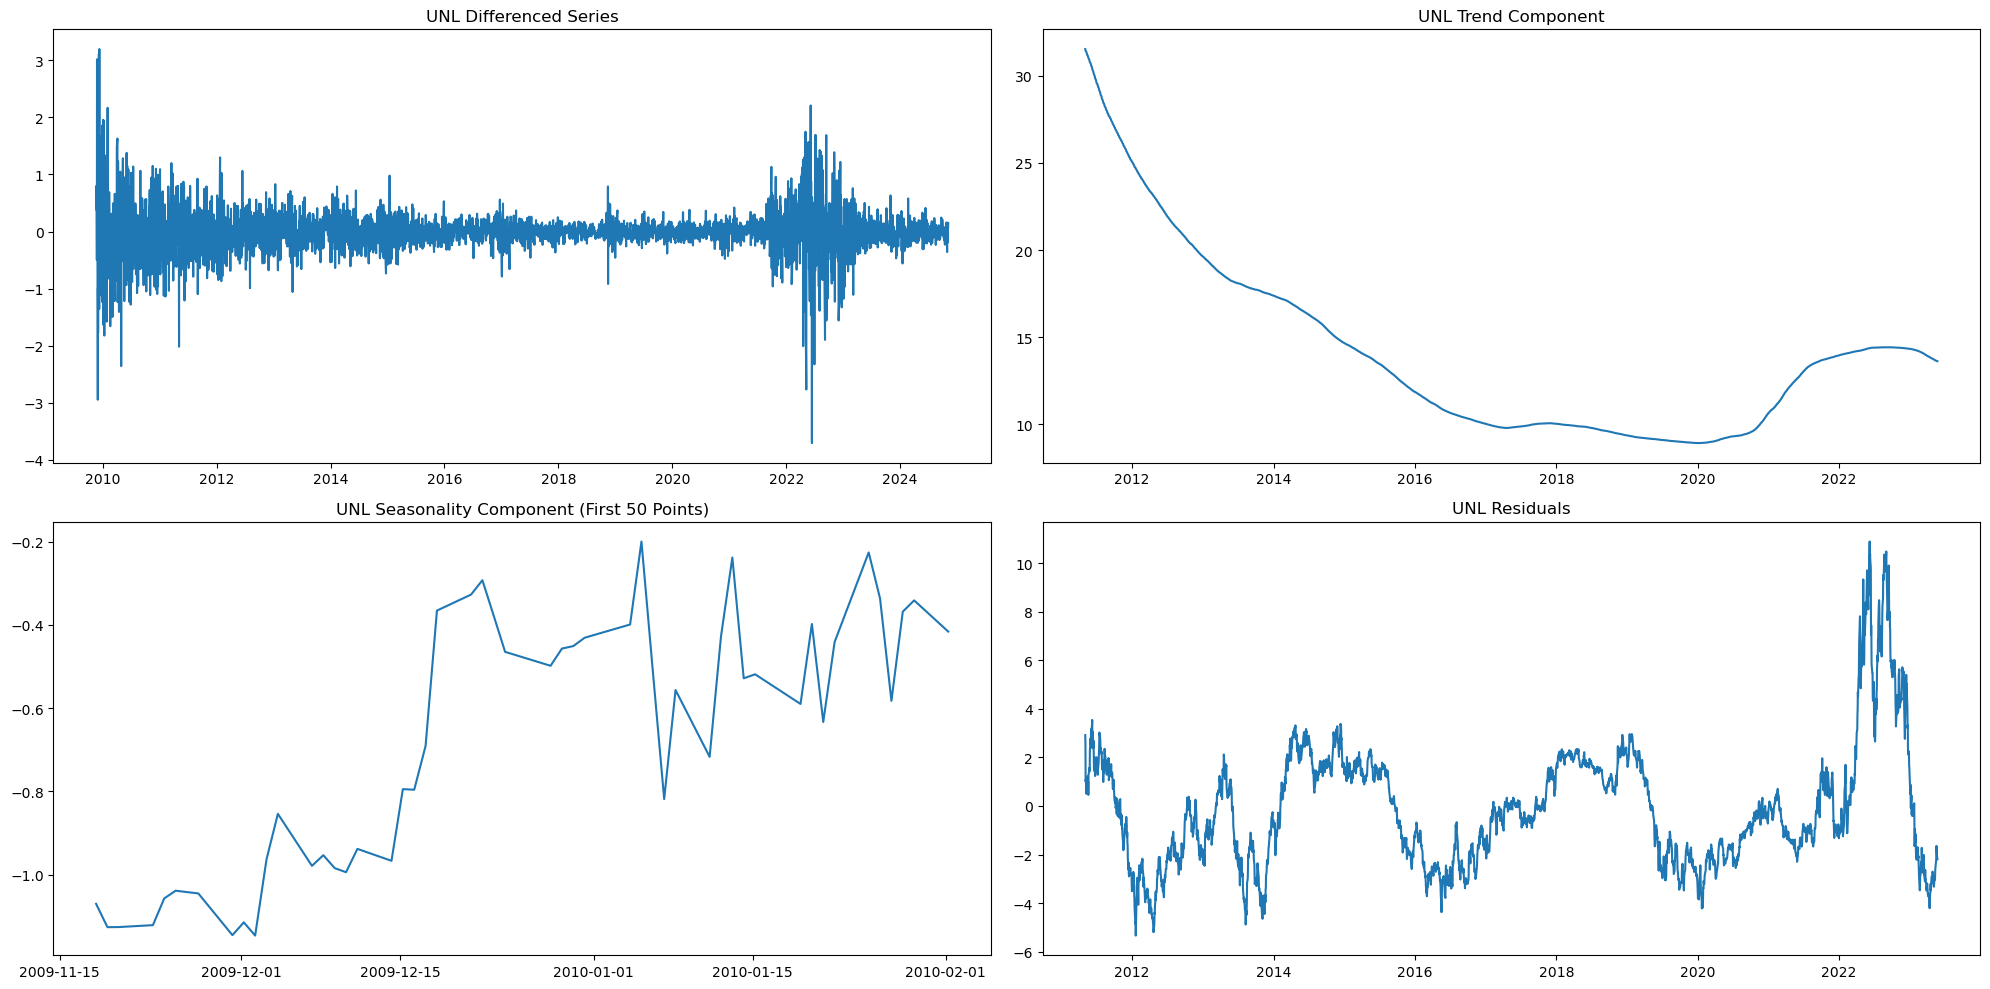

2024-11-05 17:25:07,769 - INFO - Performing seasonal decomposition with period=1825 and model='additive'...
2024-11-05 17:25:07,786 - INFO - Seasonal decomposition completed.



UNL Seasonal Decomposition:


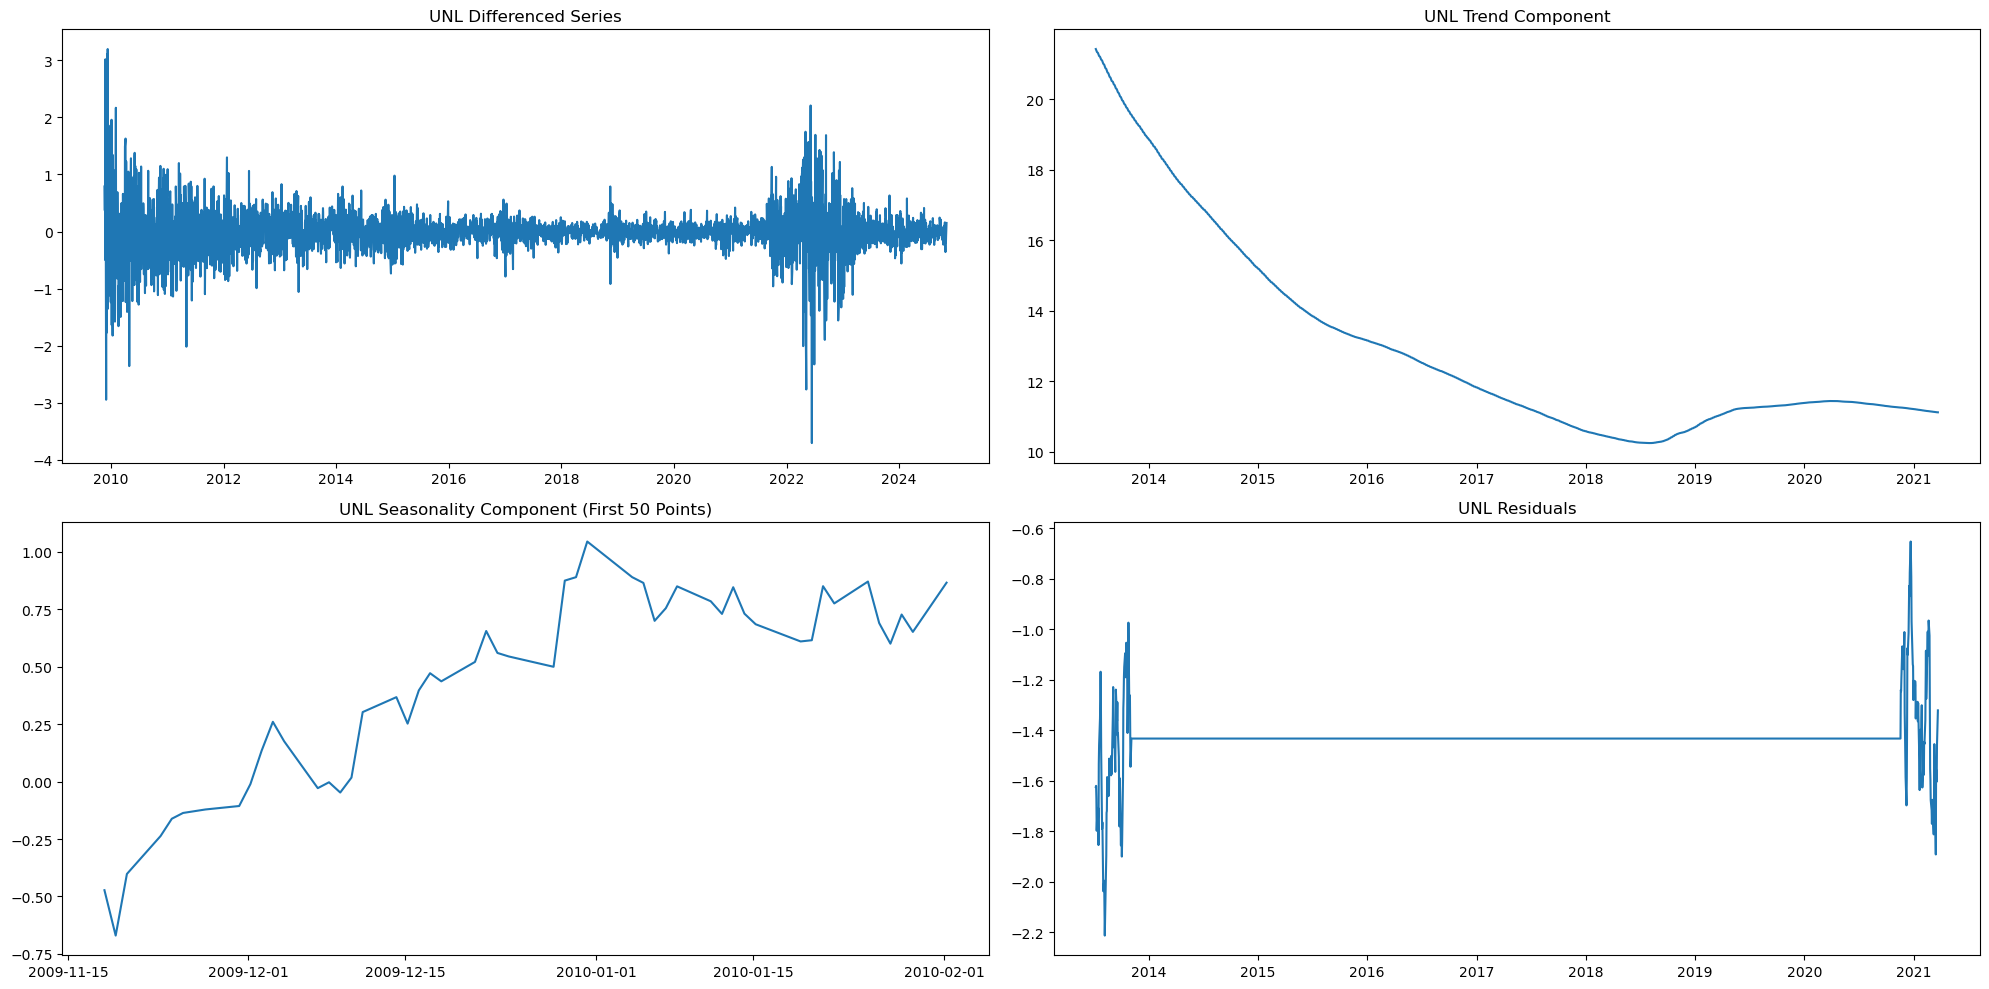

2024-11-05 17:25:08,856 - INFO - Performing seasonal decomposition with period=365 and model='additive'...
2024-11-05 17:25:08,865 - INFO - Seasonal decomposition completed.



DBA Seasonal Decomposition:


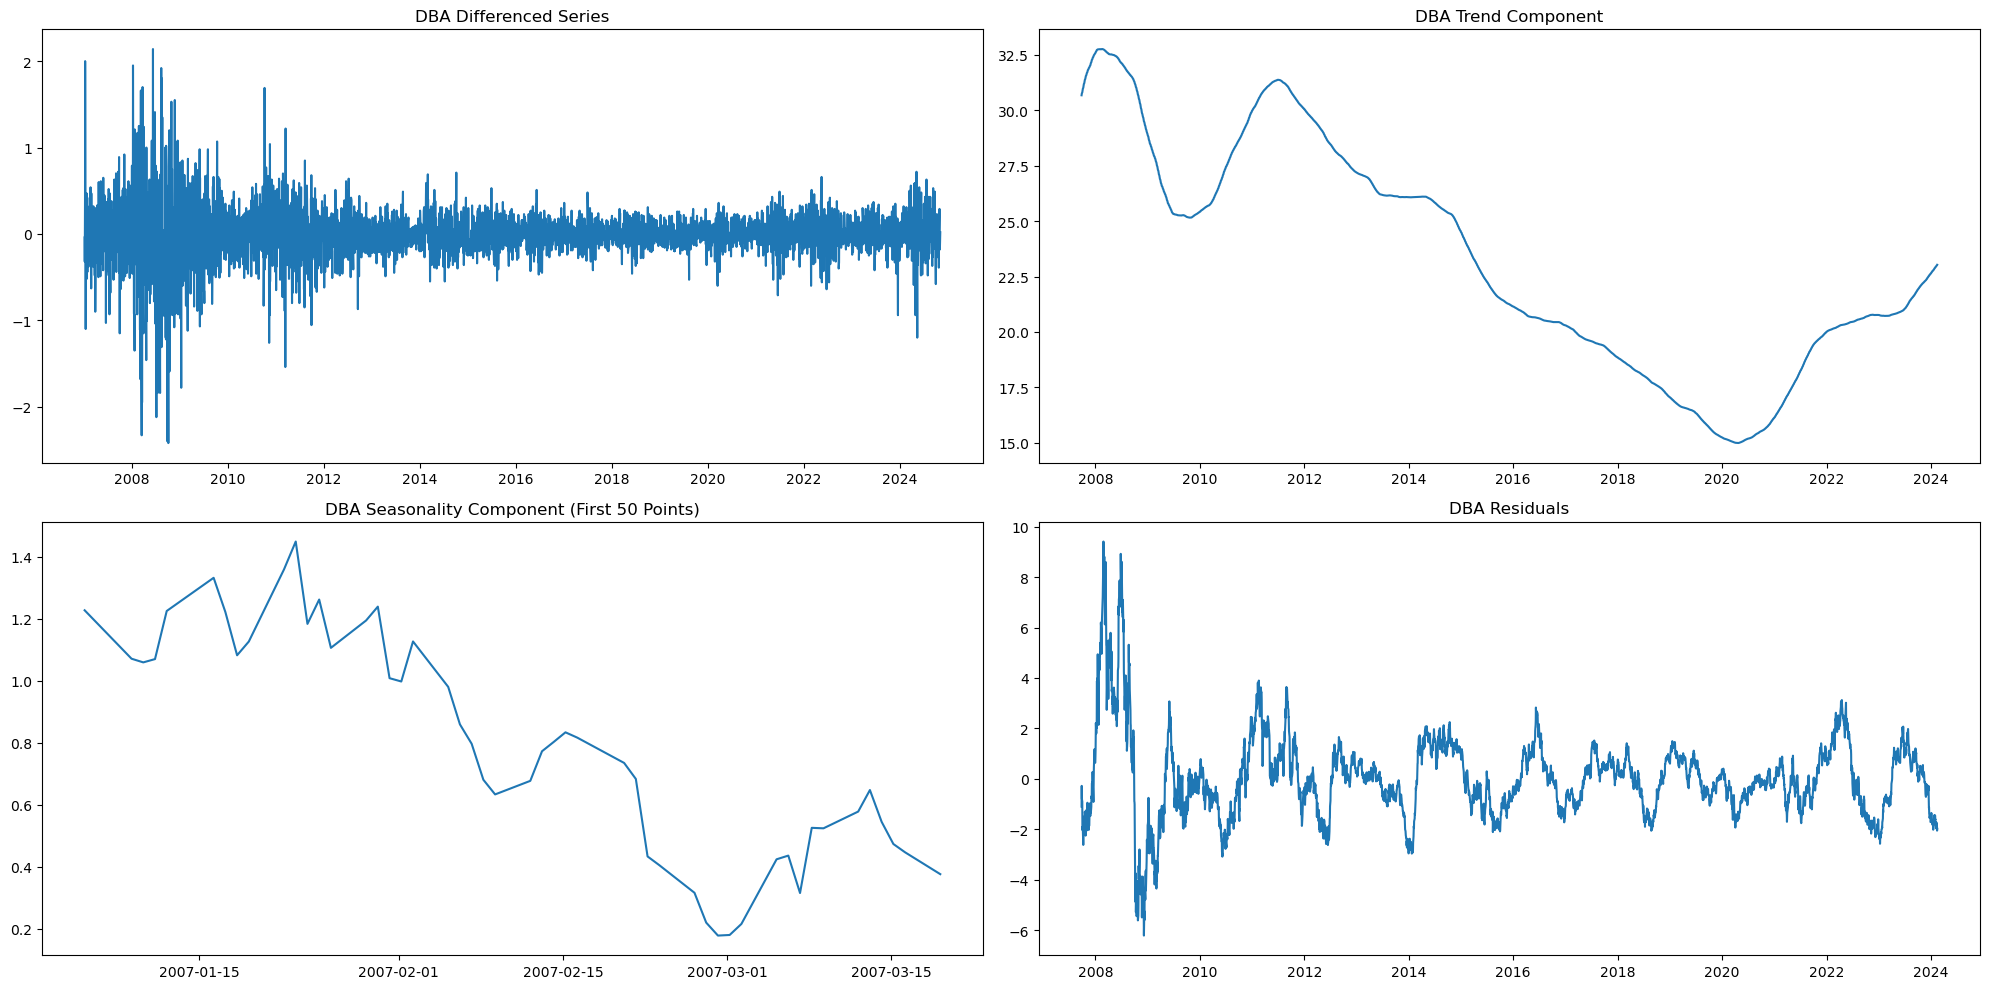

2024-11-05 17:25:09,335 - INFO - Performing seasonal decomposition with period=730 and model='additive'...
2024-11-05 17:25:09,343 - INFO - Seasonal decomposition completed.



DBA Seasonal Decomposition:


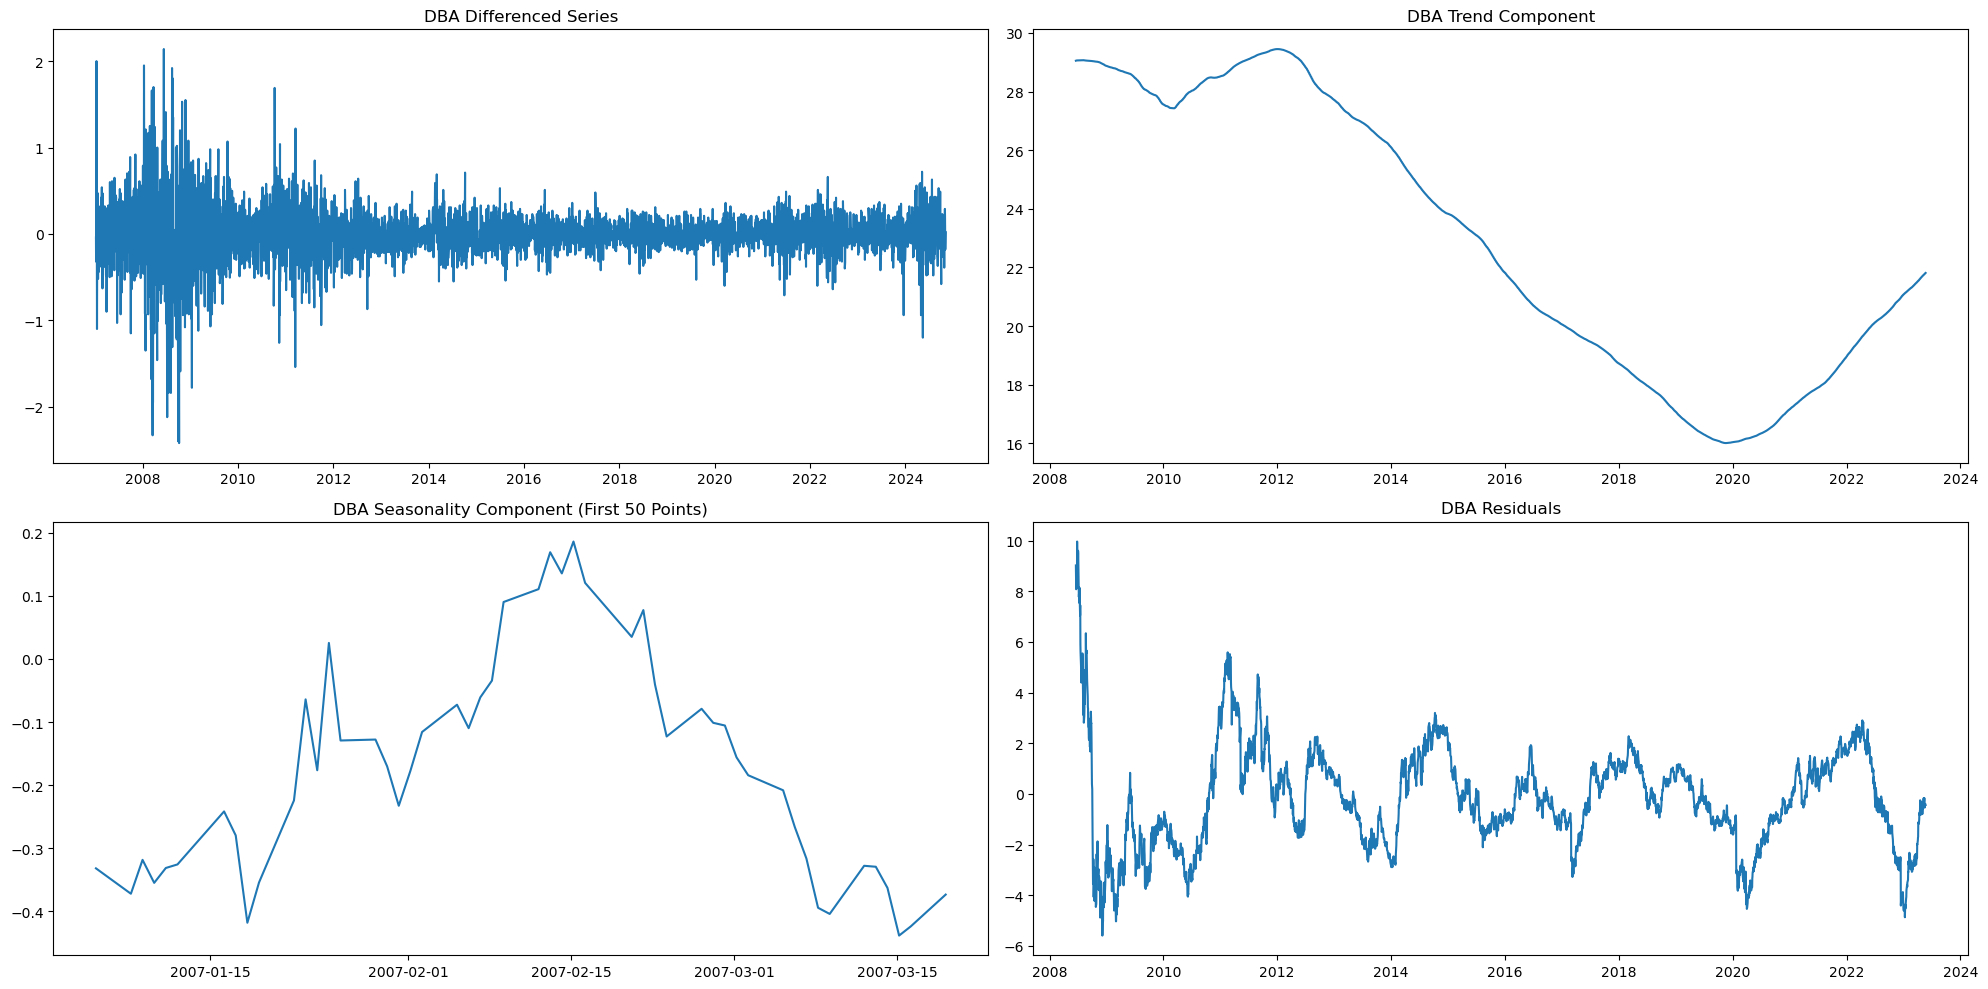

2024-11-05 17:25:09,856 - INFO - Performing seasonal decomposition with period=1825 and model='additive'...
2024-11-05 17:25:09,872 - INFO - Seasonal decomposition completed.



DBA Seasonal Decomposition:


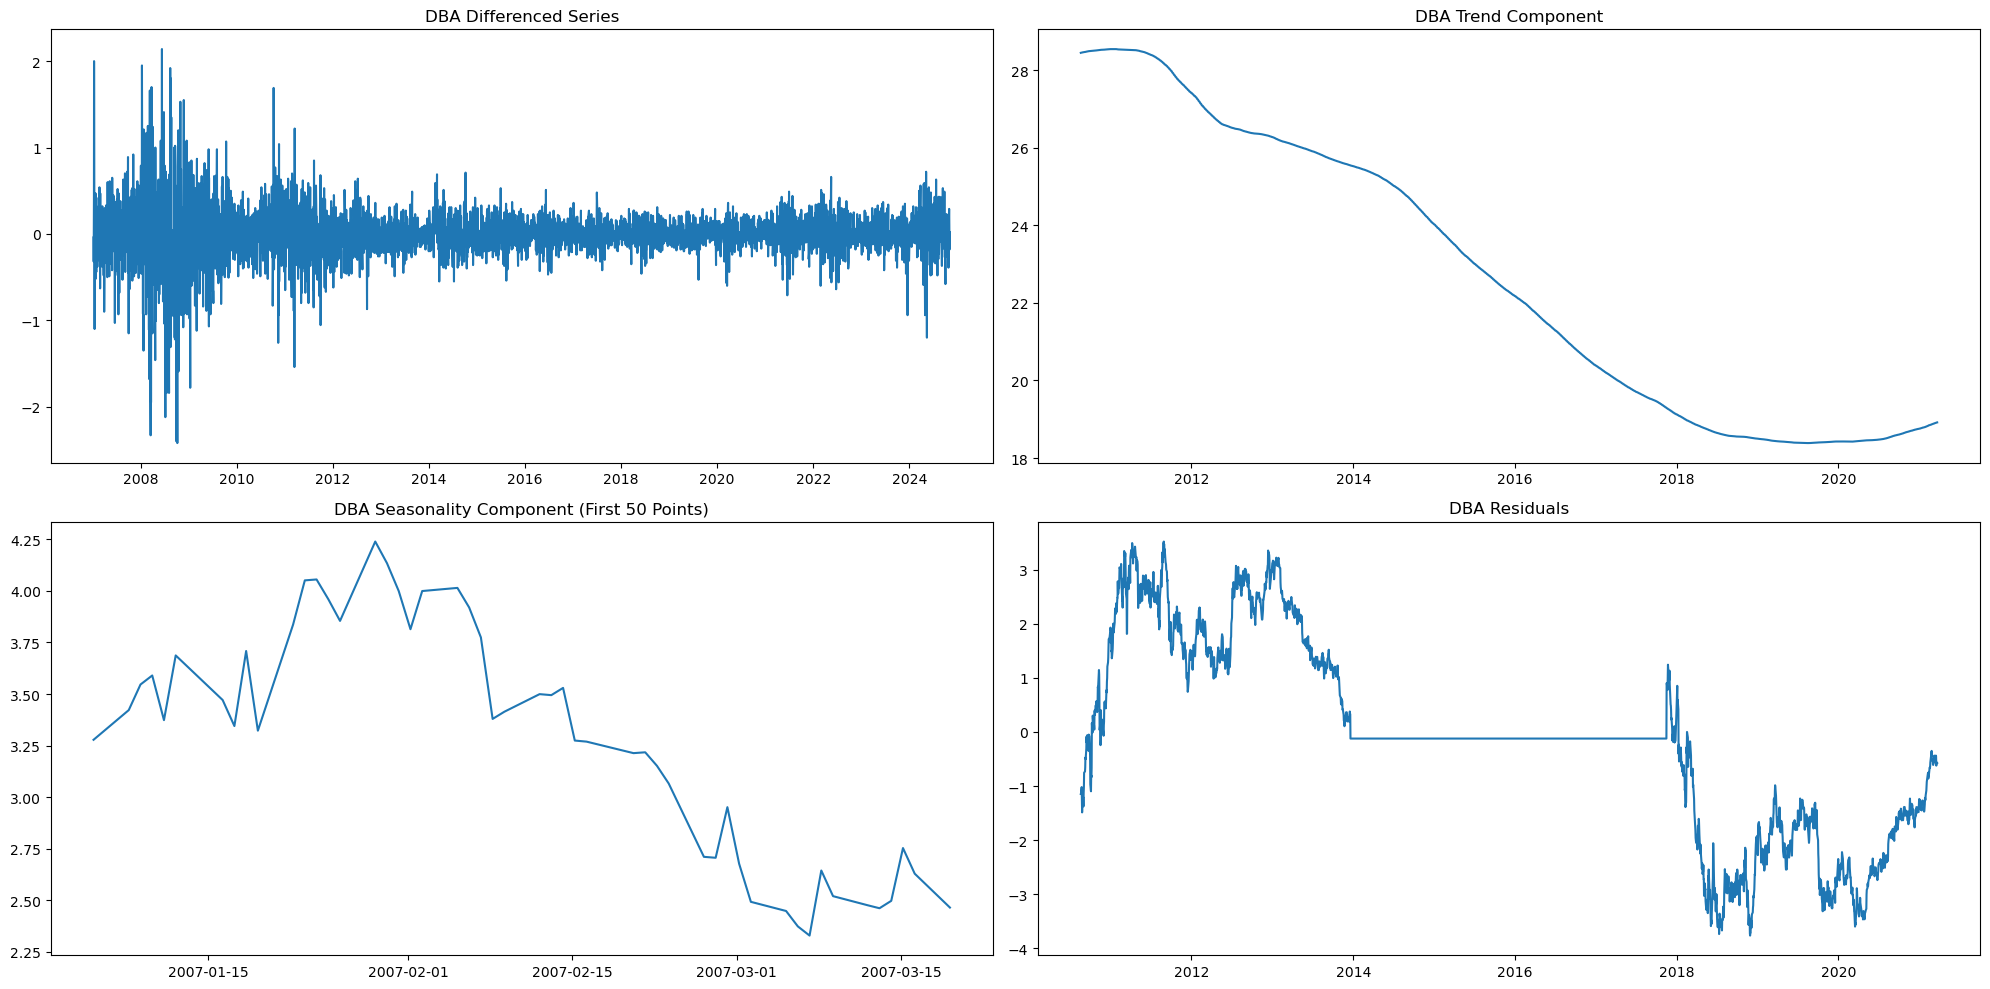

2024-11-05 17:25:10,315 - INFO - Performing seasonal decomposition with period=365 and model='additive'...
2024-11-05 17:25:10,320 - INFO - Seasonal decomposition completed.



BG Seasonal Decomposition:


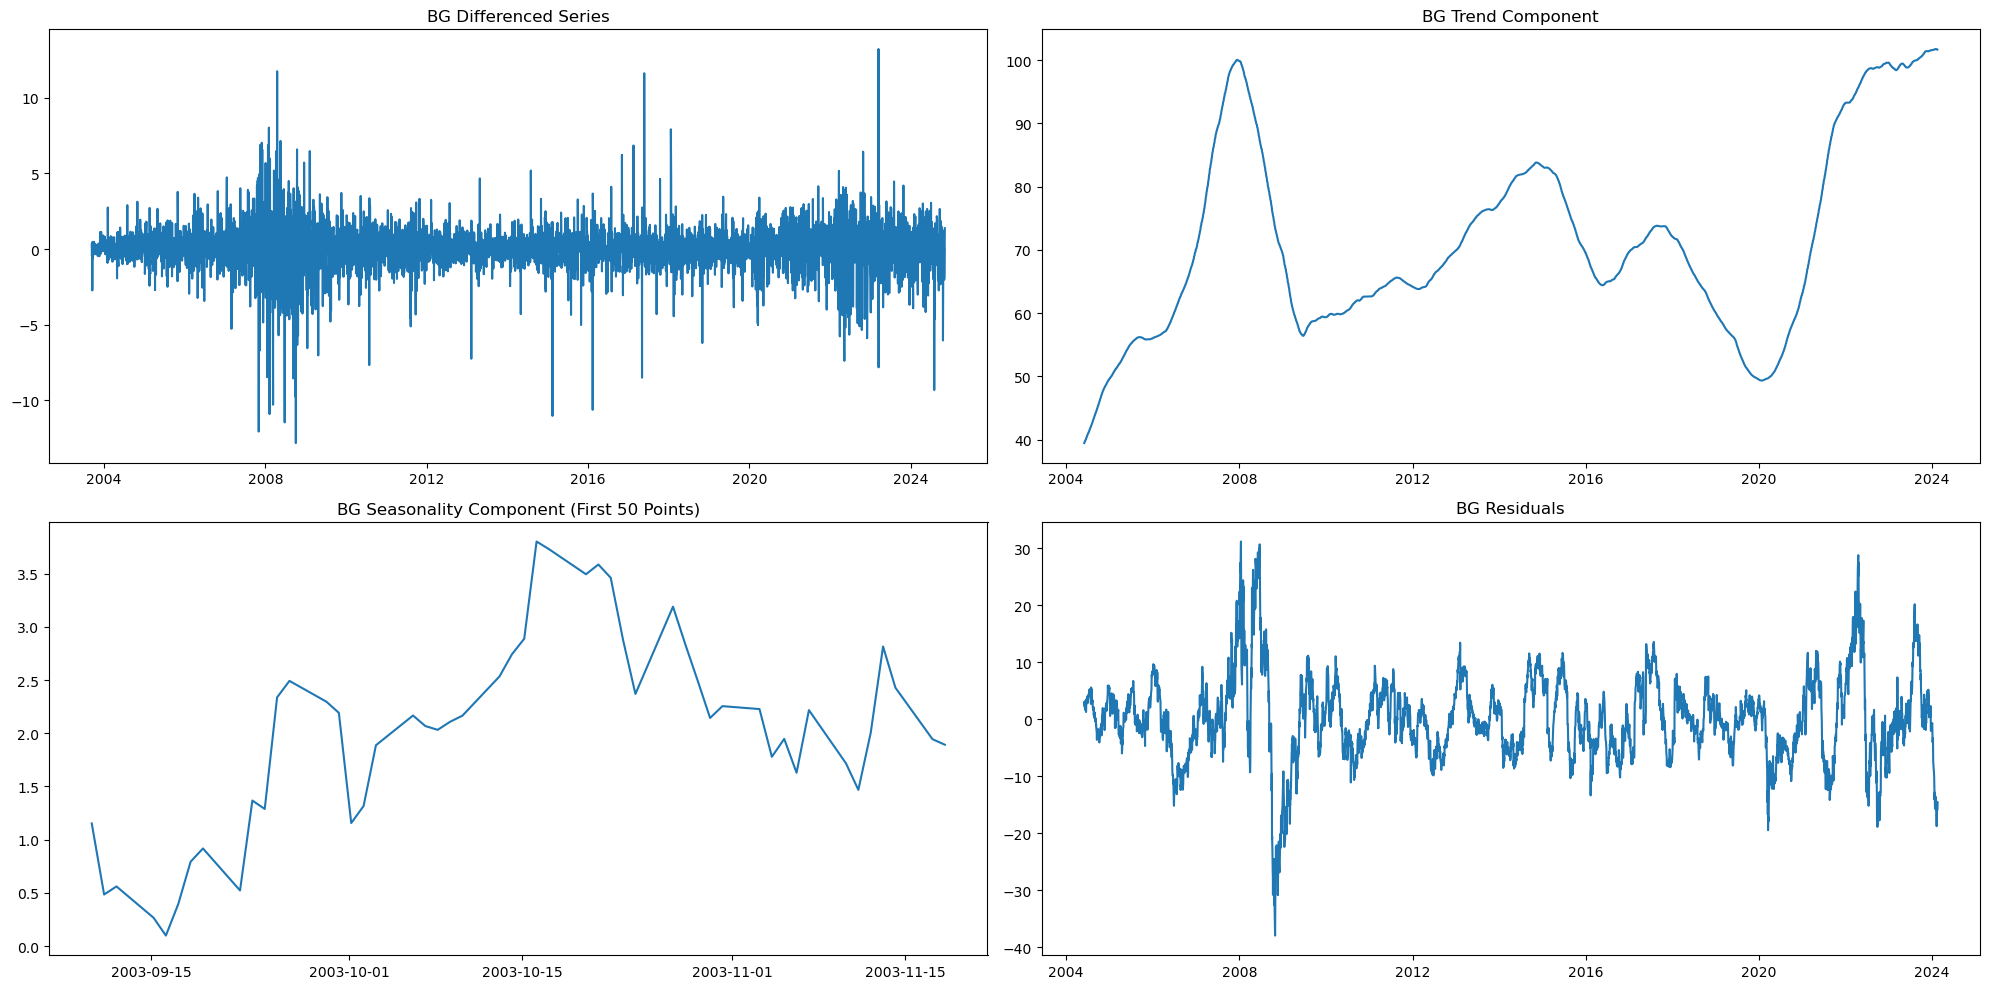

2024-11-05 17:25:10,824 - INFO - Performing seasonal decomposition with period=730 and model='additive'...
2024-11-05 17:25:10,837 - INFO - Seasonal decomposition completed.



BG Seasonal Decomposition:


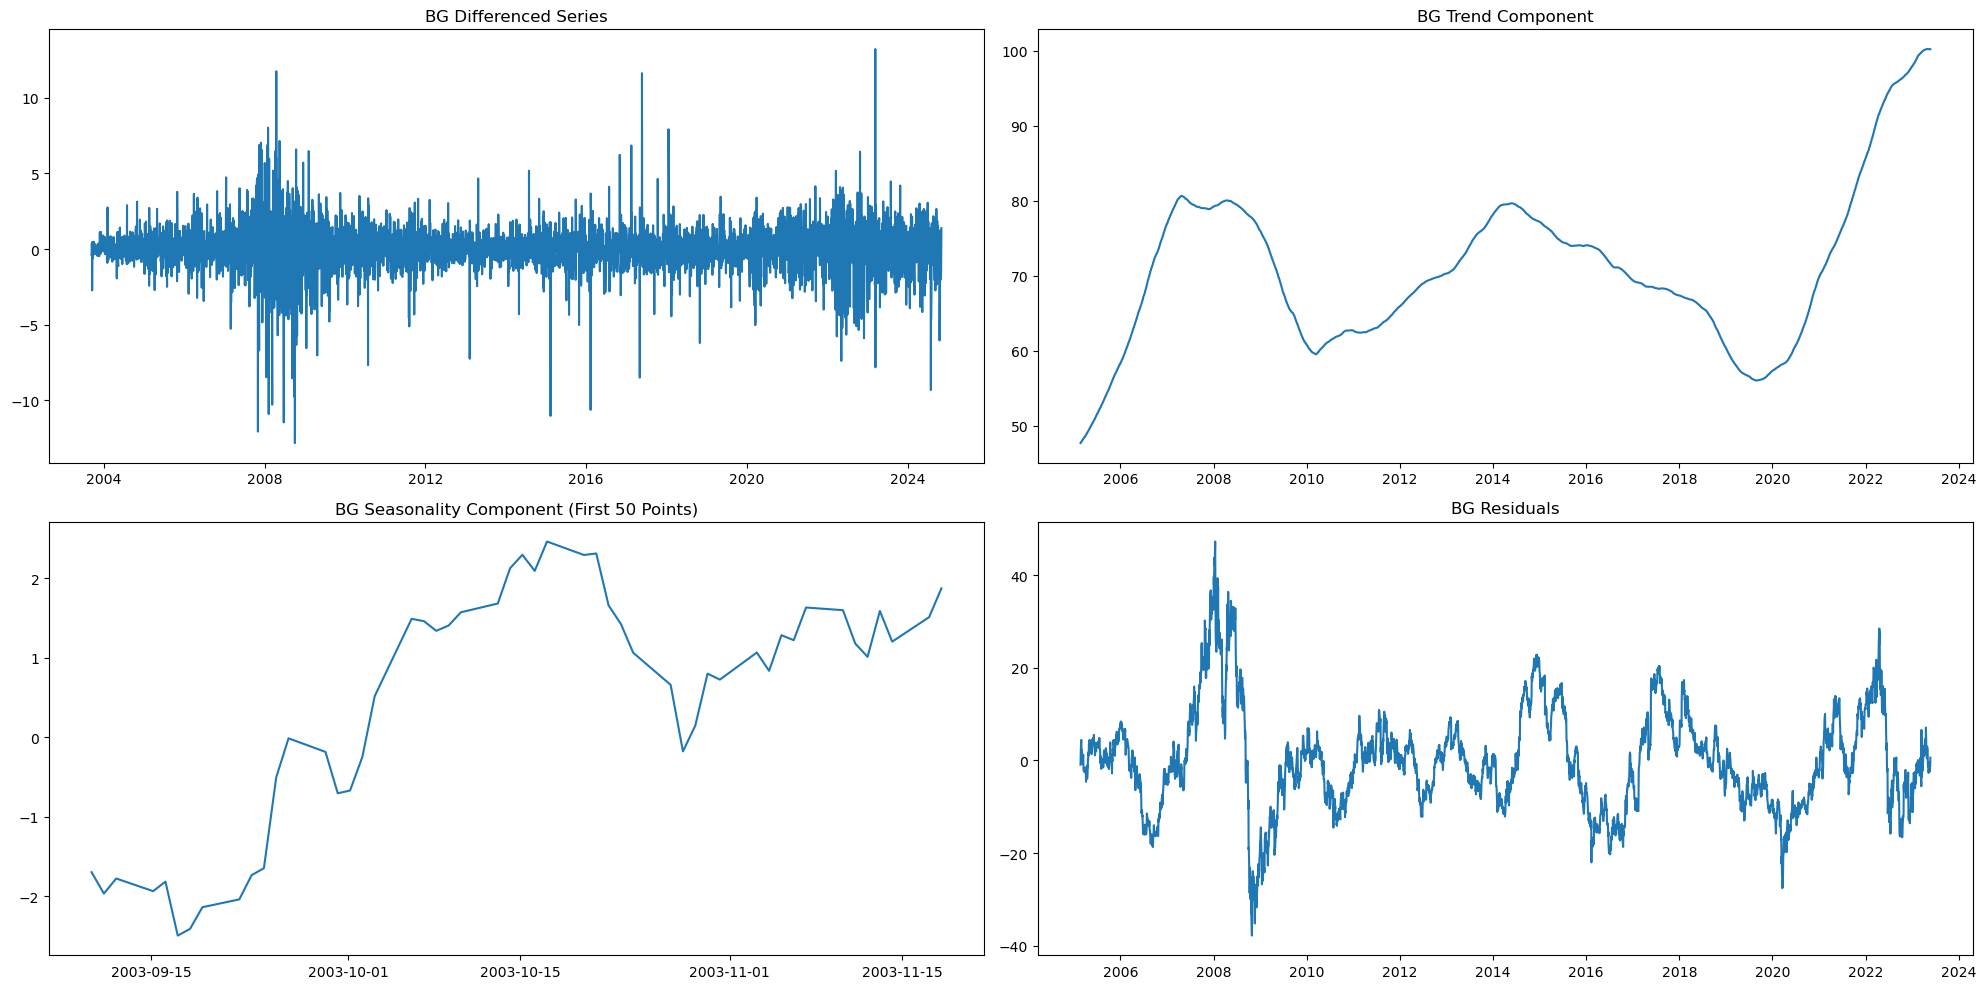

2024-11-05 17:25:11,517 - INFO - Performing seasonal decomposition with period=1825 and model='additive'...
2024-11-05 17:25:11,536 - INFO - Seasonal decomposition completed.



BG Seasonal Decomposition:


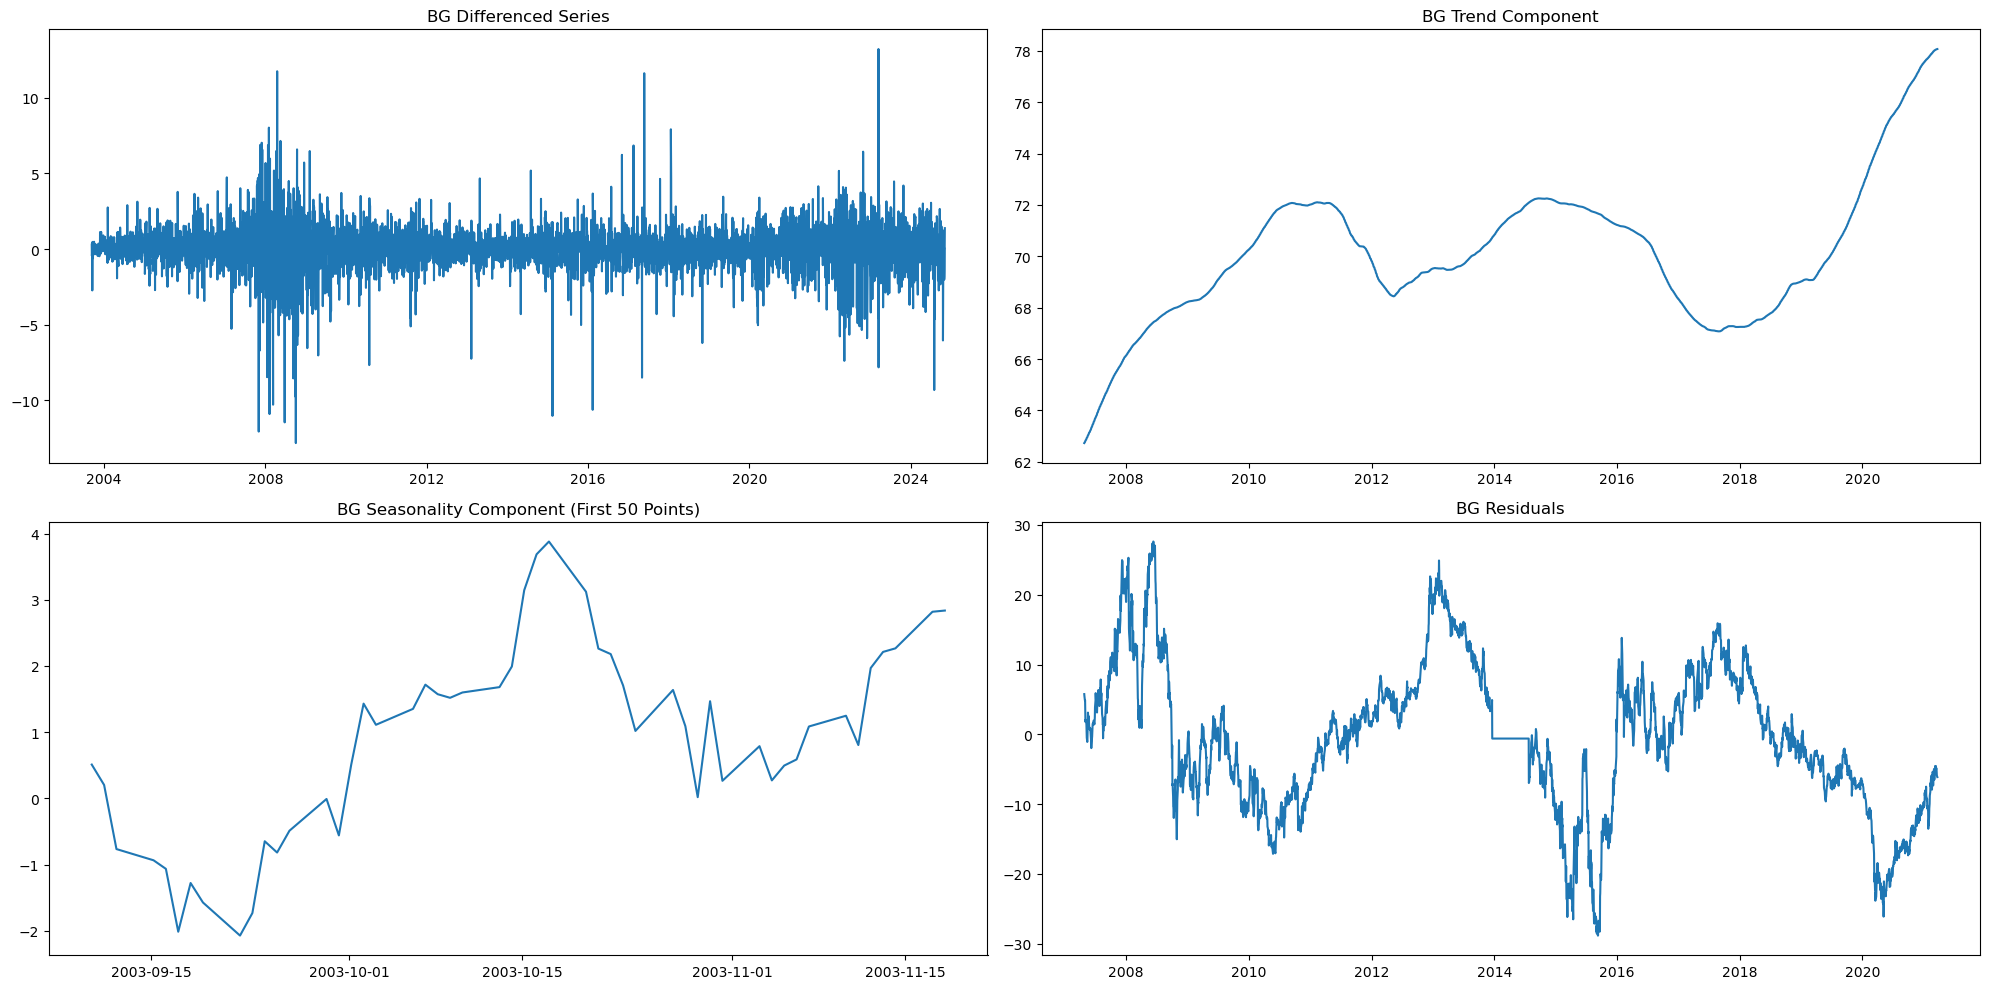

2024-11-05 17:25:11,972 - INFO - Performing seasonal decomposition with period=365 and model='additive'...
2024-11-05 17:25:11,976 - INFO - Seasonal decomposition completed.



CORN Seasonal Decomposition:


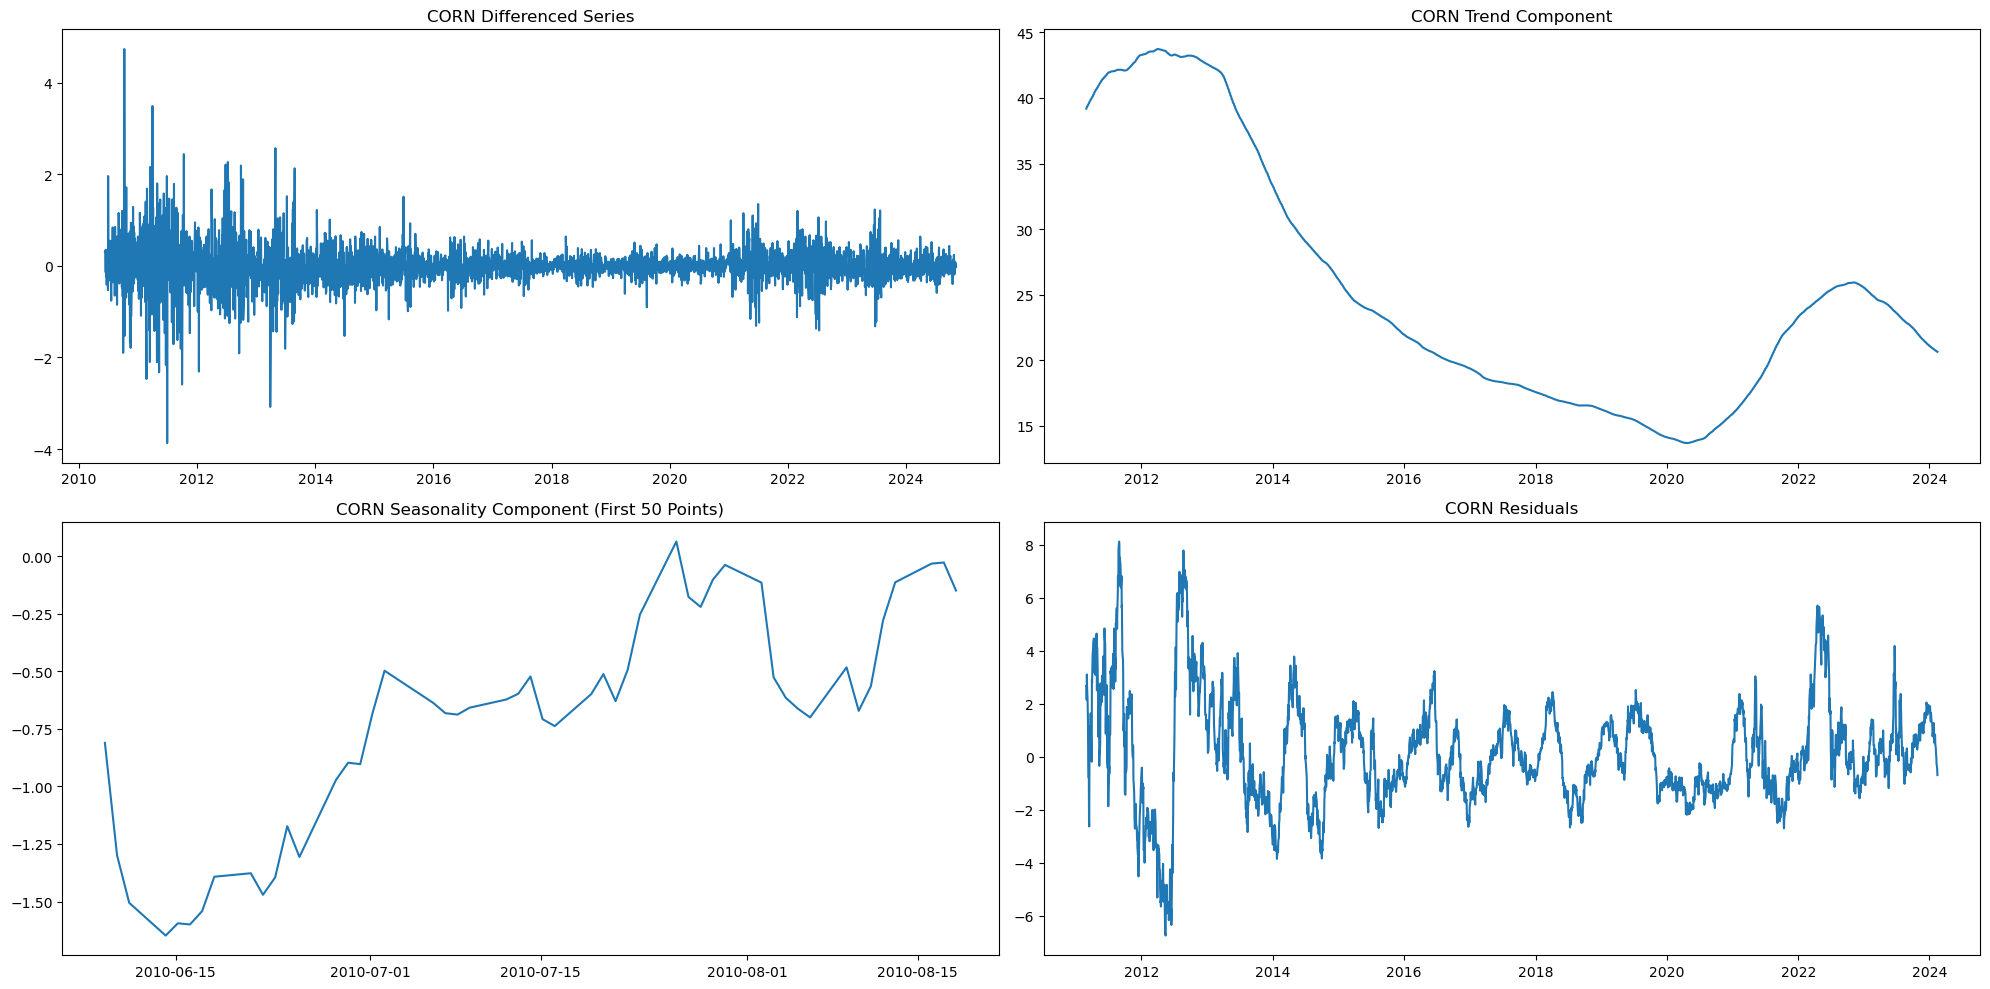

2024-11-05 17:25:12,430 - INFO - Performing seasonal decomposition with period=730 and model='additive'...
2024-11-05 17:25:12,437 - INFO - Seasonal decomposition completed.



CORN Seasonal Decomposition:


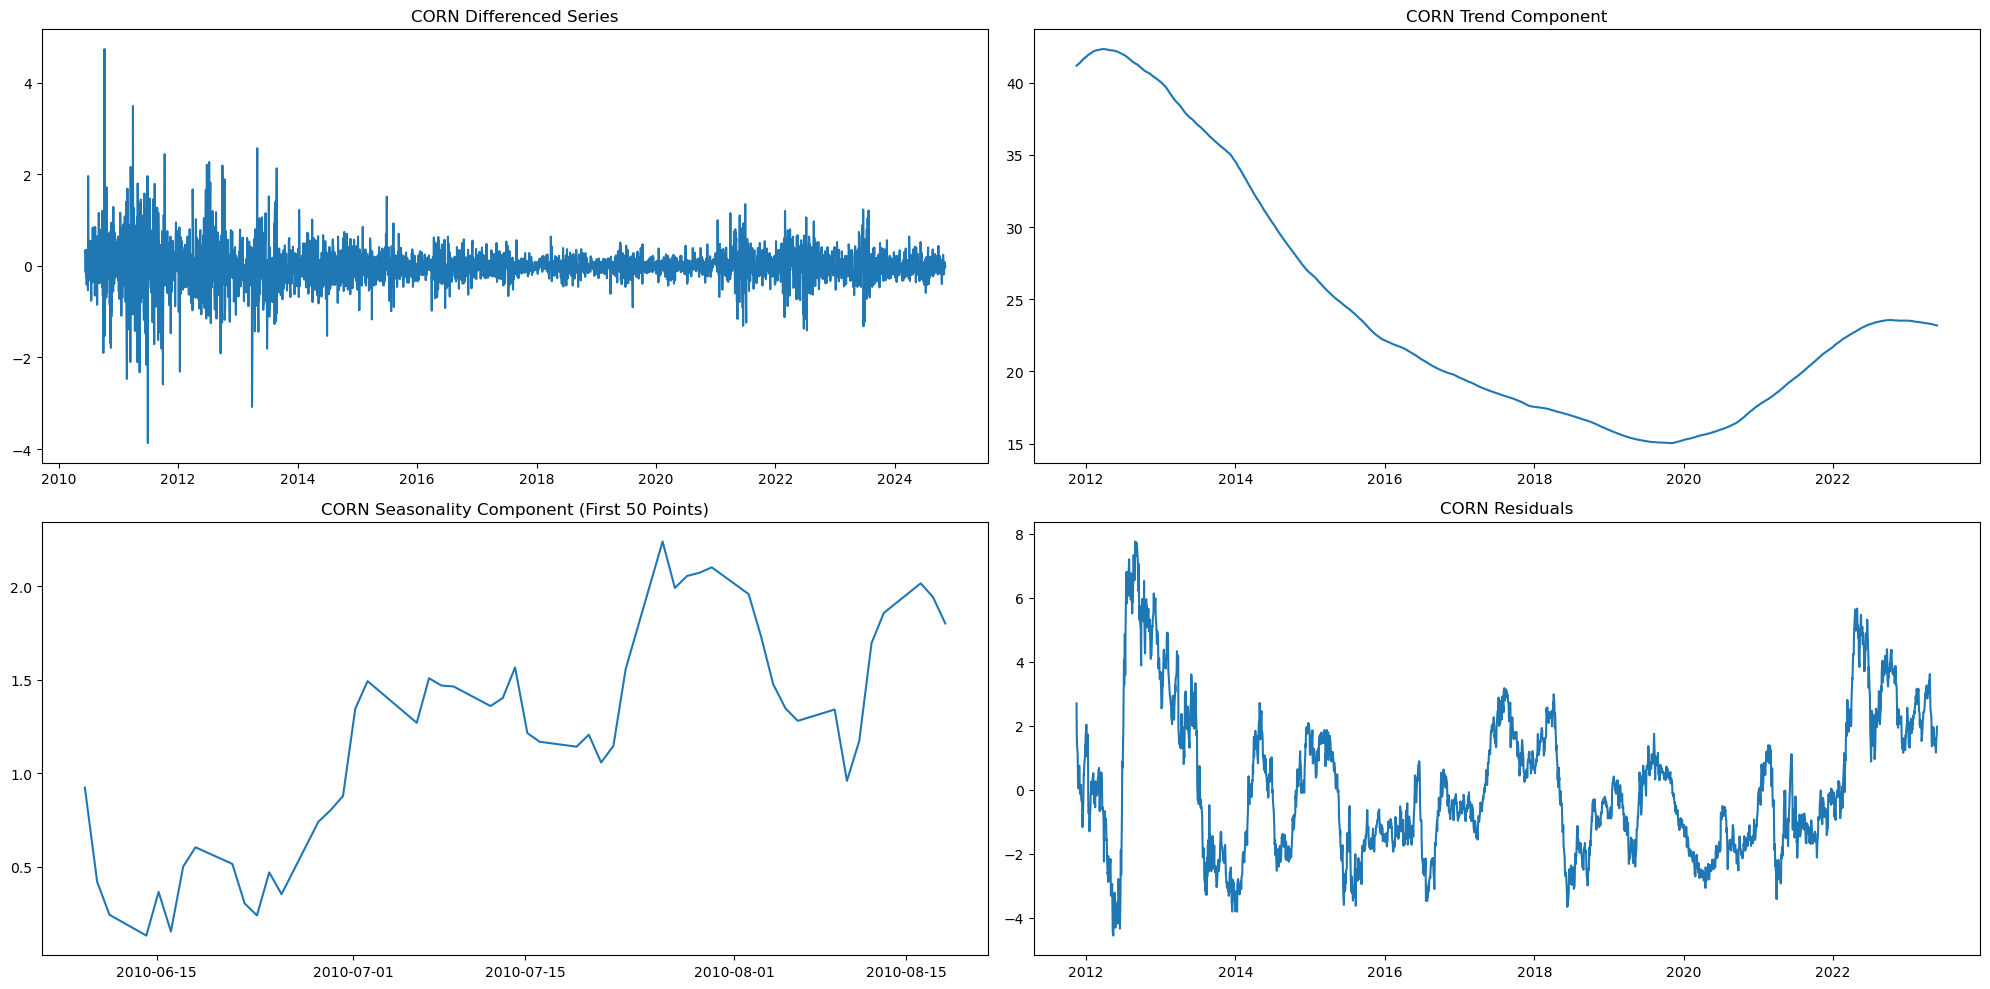

2024-11-05 17:25:12,829 - INFO - Performing seasonal decomposition with period=1825 and model='additive'...
2024-11-05 17:25:12,829 - ERROR - An error occurred during seasonal decomposition: x must have 2 complete cycles requires 3650 observations. x only has 3627 observation(s)
2024-11-05 17:25:12,830 - WARNING - Seasonal decomposition plot skipped for CORN: No valid decomposition.



CORN Seasonal Decomposition:


TypeError: cannot unpack non-iterable NoneType object

In [36]:
def plot_seasonal_decomposition(ts, ticker, seasonal_period=7):
    decomposition = seasonal_decomposition_analysis(ts, seasonal_period)

    if decomposition is None:
        logging.warning(
            f"Seasonal decomposition plot skipped for {ticker}: No valid decomposition.")
        return

    trend = decomposition.trend
    seasonality = decomposition.seasonal
    resid = decomposition.resid

    fig = plt.figure(figsize=(20, 10))

    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)

    ax1.plot(ts.diff().dropna())
    ax1.set_title(f"{ticker} Differenced Series")

    ax2.plot(trend)
    ax2.set_title(f"{ticker} Trend Component")

    ax3.plot(seasonality[:50])
    ax3.set_title(f"{ticker} Seasonality Component (First 50 Points)")

    ax4.plot(resid)
    ax4.set_title(f"{ticker} Residuals")

    plt.tight_layout()
    plt.show()
    return trend, seasonality, resid


for ticker in tickers:
    for period in [365, 730, 1825]:
        print(f"\n{ticker} Seasonal Decomposition:")
        close_series = asset_data[ticker]['Close']
        trend, seasonality, resid = plot_seasonal_decomposition(close_series, ticker, seasonal_period=period)

In [24]:

def plot_acf_pacf(series, lags=40, title=''):
    """
    Plots ACF and PACF for the given series.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    plot_acf(series, lags=lags, ax=axes[0], zero=False)
    axes[0].set_title(f"ACF {title}")
    plot_pacf(series, lags=lags, ax=axes[1], zero=False)
    axes[1].set_title(f"PACF {title}")
    plt.tight_layout()
    plt.show()


Plotting ACF and PACF for GLD...


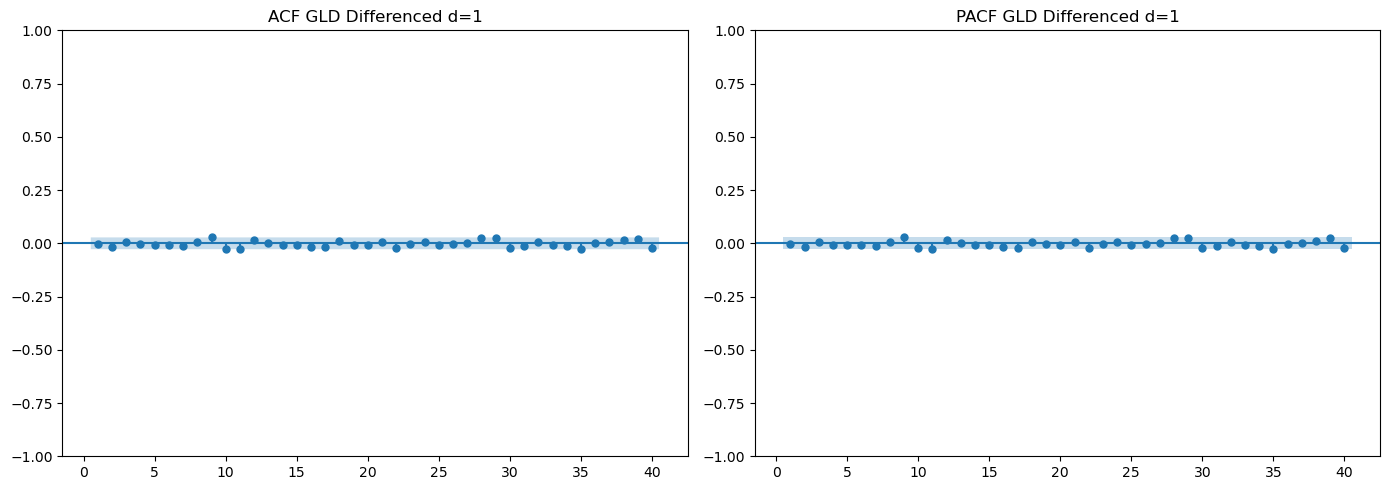


Plotting ACF and PACF for SLV...


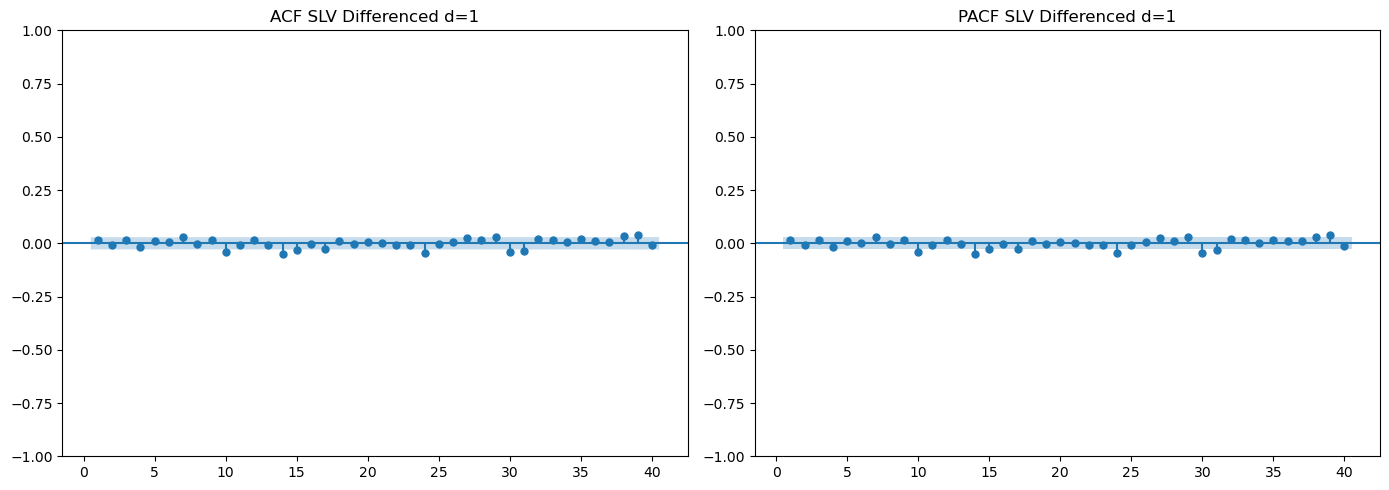


Plotting ACF and PACF for UNL...


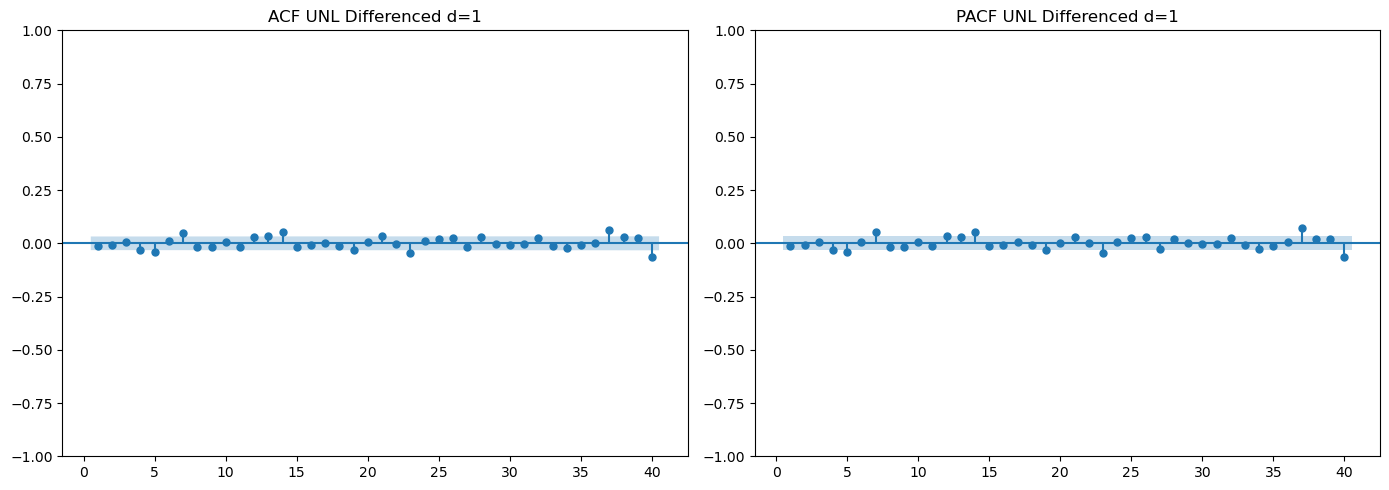


Plotting ACF and PACF for DBA...


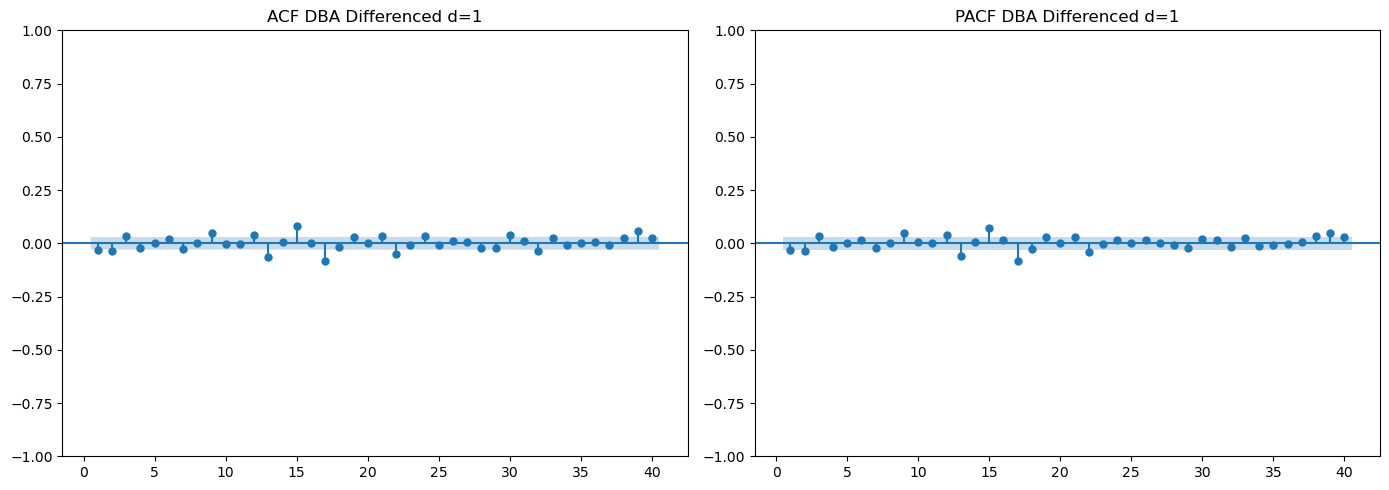


Plotting ACF and PACF for BG...


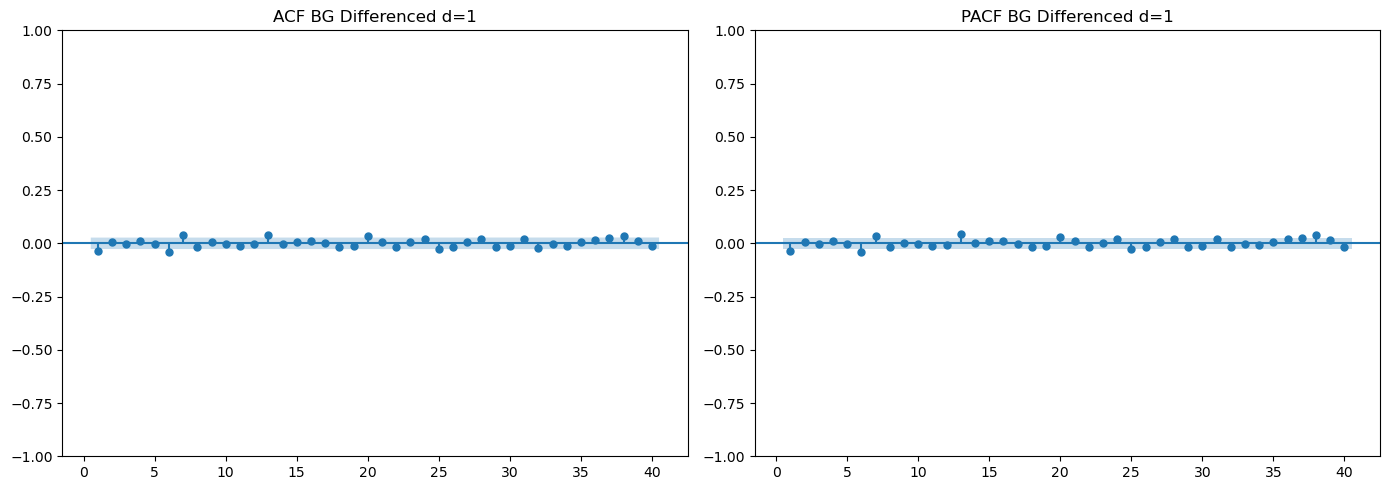


Plotting ACF and PACF for CORN...


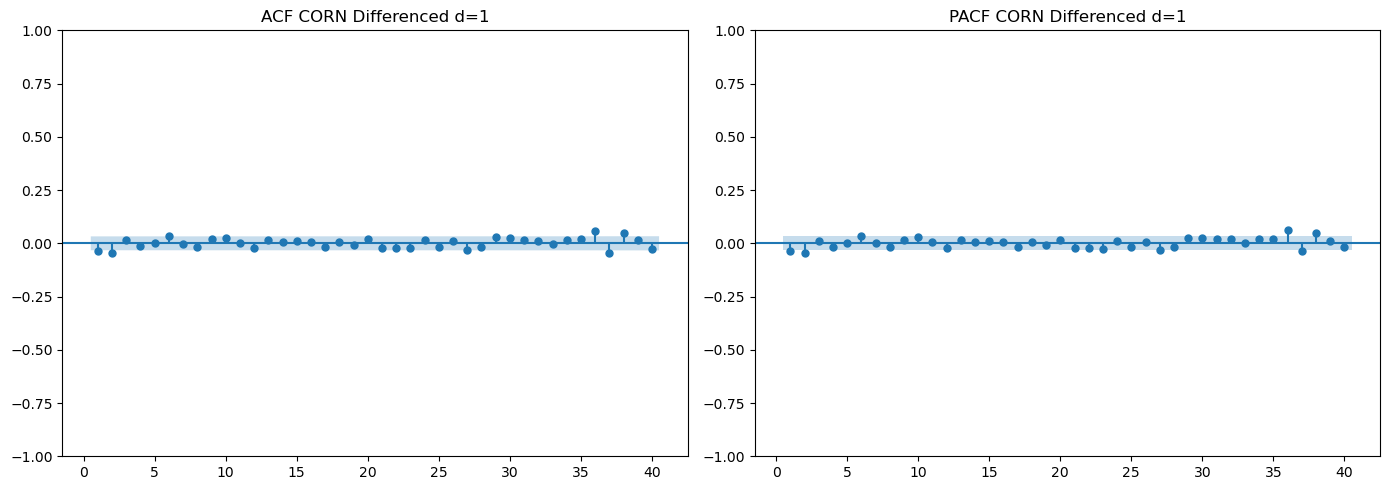


Plotting ACF and PACF for WEAT...


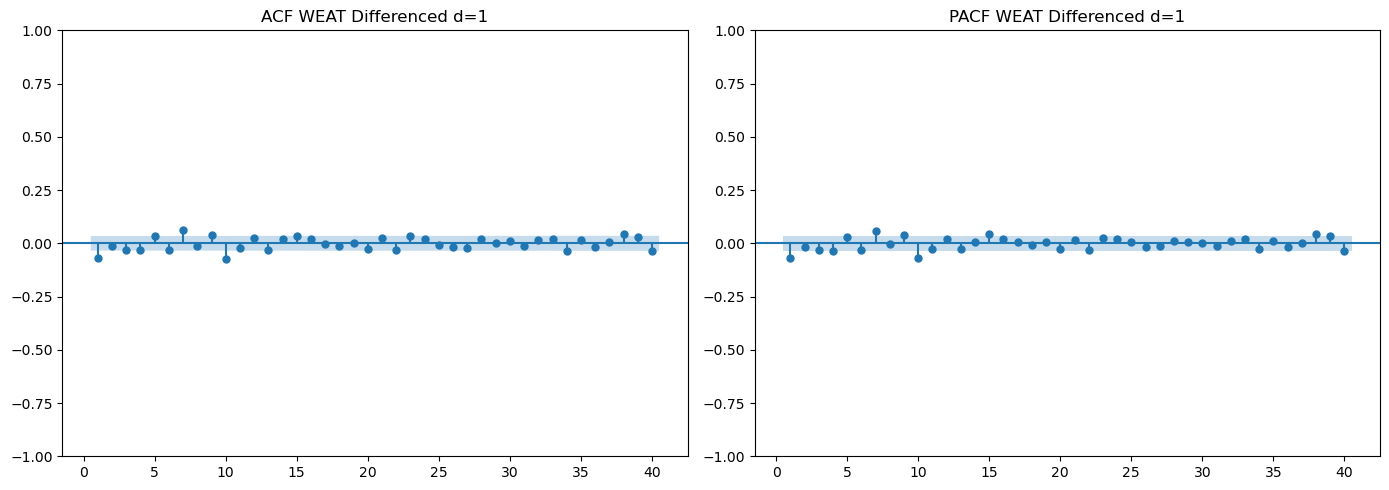

In [25]:
for ticker in tickers:
    print(f"\nPlotting ACF and PACF for {ticker}...")
    d = d_values[ticker]
    differenced_series = asset_data[ticker]['Close'].diff(d).dropna()
    plot_acf_pacf(differenced_series, title=f"{ticker} Differenced d={d}")

In [26]:
def auto_arima_grid_search_over_seasonal_periods(series, m_values, max_p=3, max_q=3, max_P=2, max_Q=2, max_d=2, max_D=1, verbose=False):
    """
    Performs grid search over different seasonal periods to find the optimal SARIMA parameters.

    Parameters:
        series (pd.Series): The time series data.
        m_values (list): List of seasonal periods to try.
        max_p, max_q, max_P, max_Q (int): Maximum values for AR and MA terms.
        max_d, max_D (int): Maximum values for differencing terms.
        verbose (bool): If True, prints detailed information.

    Returns:
        dict: A dictionary containing the best models for each seasonal period and the overall best model.
    """
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None
    best_m = None
    results = []

    for m in m_values:
        if verbose:
            print(f"\nTesting seasonal period m={m}")
        try:
            stepwise_model = pm.auto_arima(series, start_p=0, start_q=0,
                                           max_p=max_p, max_q=max_q,
                                           d=None, max_d=max_d,
                                           start_P=0, start_Q=0,
                                           max_P=max_P, max_Q=max_Q,
                                           D=None, max_D=max_D,
                                           seasonal=True, m=m,
                                           trace=verbose,
                                           error_action='ignore',
                                           suppress_warnings=True,
                                           stepwise=True,
                                           information_criterion='aic')
            aic = stepwise_model.aic()
            results.append({'m': m, 'model': stepwise_model, 'aic': aic})

            if aic < best_aic:
                best_aic = aic
                best_order = stepwise_model.order
                best_seasonal_order = stepwise_model.seasonal_order
                best_m = m
                best_model = stepwise_model
                if verbose:
                    print(f"New best model found for m={m} with AIC={aic}")

        except Exception as e:
            if verbose:
                print(f"Failed to fit SARIMA model for m={m}: {e}")
            continue

    if verbose and best_m is not None:
        print(
            f"\nBest model overall: Seasonal Period m={best_m}, Order={best_order}, Seasonal Order={best_seasonal_order}, AIC={best_aic}")

    return {'best_model': best_model, 'best_m': best_m, 'results': results}

In [27]:
# Define a range of seasonal periods to test
m_values = [1, 2, 7, 14, 30]

In [28]:
# Dictionaries to hold best models and seasonal periods
best_models = {}
best_m_values = {}

for ticker in tickers:
    print(f"\nPerforming grid search over seasonal periods for {ticker}:")
    series = asset_data[ticker]['Close']
    grid_search_results = auto_arima_grid_search_over_seasonal_periods(
        series, m_values, verbose=True)

    # Extract the best model and seasonal period
    best_model = grid_search_results['best_model']
    best_m = grid_search_results['best_m']

    if best_model is not None and best_m is not None:
        best_models[ticker] = best_model
        best_m_values[ticker] = best_m
        print(f"\nBest seasonal period for {ticker}: m={best_m}")
    else:
        logging.error(f"Grid search failed for {ticker}.")


Performing grid search over seasonal periods for GLD:

Testing seasonal period m=1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17514.233, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17516.149, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17516.146, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17516.755, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17515.487, Time=0.93 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.457 seconds
New best model found for m=1 with AIC=17514.232932612096

Testing seasonal period m=2
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=20972.068, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=18739.964, Time=0.39 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=20979.113, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[2] intercept   : AIC=19603.355, Time=0.19 sec
 AR

KeyboardInterrupt: 

In [14]:
for ticker in tickers:
    grid_search_results = best_models[ticker]
    results = [result for result in grid_search_results['results']]
    if results:
        aic_values = [result['aic'] for result in results]
        m_tested = [result['m'] for result in results]

        plt.figure(figsize=(10, 6))
        plt.plot(m_tested, aic_values, marker='o')
        plt.title(f'{ticker}: AIC vs. Seasonal Period (m)')
        plt.xlabel('Seasonal Period (m)')
        plt.ylabel('AIC')
        plt.xticks(m_tested)
        plt.grid(True)
        plt.show()

TypeError: 'ARIMA' object is not subscriptable

In [ ]:
for ticker in tickers:
    if ticker in best_models:
        print(f"\nBuilding model and forecasting for {ticker}...")
        series = asset_data[ticker]['Close']

        # Split data into training and testing sets
        train_size = int(len(series) * 0.8)
        train_data, test_data = series[:train_size], series[train_size:]

        # Get best order and seasonal order
        best_model = best_models[ticker]
        best_order = best_model.order
        best_seasonal_order = best_model.seasonal_order
        best_m = best_m_values[ticker]

        # Fit the model on training data
        model = SARIMAX(train_data,
                        order=best_order,
                        seasonal_order=(*best_seasonal_order[:3], best_m),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        sarima_fit = model.fit(disp=False)

        print(f"\n{ticker} Best SARIMA Model Summary:")
        print(sarima_fit.summary())

        # Forecast
        forecast_steps = len(test_data)
        forecast = sarima_fit.get_forecast(steps=forecast_steps)
        predicted_mean = forecast.predicted_mean
        confidence_intervals = forecast.conf_int()

        # Evaluation
        mse = mean_squared_error(test_data, predicted_mean)
        mae = mean_absolute_error(test_data, predicted_mean)

        print(f"\n{ticker} Mean Squared Error (MSE): {mse}")
        print(f"{ticker} Mean Absolute Error (MAE): {mae}")

        # Plot
        plt.figure(figsize=(14, 7))
        plt.plot(test_data.index, test_data,
                 label=f'Actual {ticker} Prices', color='blue')
        plt.plot(test_data.index, predicted_mean,
                 label=f'Predicted {ticker} Prices', color='red', linestyle='--')
        plt.fill_between(test_data.index,
                         confidence_intervals['lower Close'],
                         confidence_intervals['upper Close'],
                         color='pink', alpha=0.3)
        plt.title(f'{ticker} SARIMA Forecast (Seasonal Period m={best_m})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Residual Diagnostics
        residuals = sarima_fit.resid
        plt.figure(figsize=(14, 7))
        plt.plot(residuals, label='Residuals', color='purple')
        plt.title(f'{ticker} Residuals')
        plt.xlabel('Date')
        plt.ylabel('Residuals')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # ACF and PACF of Residuals
        plot_acf_pacf(residuals.dropna(), title=f'{ticker} Residuals')
    else:
        logging.error(f"No best model found for {ticker}.")